In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle

import robustness_model

In [ ]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [ ]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [ ]:
X_train = X_train[(y_train == 0) | (y_train == 1)].reshape(-1, 28*28) / 255
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_test = X_test[(y_test == 0) | (y_test == 1)].reshape(-1, 28*28) / 255
y_test = y_test[(y_test == 0) | (y_test == 1)]

In [ ]:
original_dim = 28*28
dim = 10000

In [ ]:
torch.linspace(0.01, 2, 100)

tensor([0.0100, 0.0301, 0.0502, 0.0703, 0.0904, 0.1105, 0.1306, 0.1507, 0.1708,
        0.1909, 0.2110, 0.2311, 0.2512, 0.2713, 0.2914, 0.3115, 0.3316, 0.3517,
        0.3718, 0.3919, 0.4120, 0.4321, 0.4522, 0.4723, 0.4924, 0.5125, 0.5326,
        0.5527, 0.5728, 0.5929, 0.6130, 0.6331, 0.6532, 0.6733, 0.6934, 0.7135,
        0.7336, 0.7537, 0.7738, 0.7939, 0.8140, 0.8341, 0.8542, 0.8743, 0.8944,
        0.9145, 0.9346, 0.9547, 0.9748, 0.9949, 1.0151, 1.0352, 1.0553, 1.0754,
        1.0955, 1.1156, 1.1357, 1.1558, 1.1759, 1.1960, 1.2161, 1.2362, 1.2563,
        1.2764, 1.2965, 1.3166, 1.3367, 1.3568, 1.3769, 1.3970, 1.4171, 1.4372,
        1.4573, 1.4774, 1.4975, 1.5176, 1.5377, 1.5578, 1.5779, 1.5980, 1.6181,
        1.6382, 1.6583, 1.6784, 1.6985, 1.7186, 1.7387, 1.7588, 1.7789, 1.7990,
        1.8191, 1.8392, 1.8593, 1.8794, 1.8995, 1.9196, 1.9397, 1.9598, 1.9799,
        2.0000])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

In [ ]:
X_train.shape, X_test.shape

(torch.Size([1692, 784]), torch.Size([423, 784]))

In [ ]:
thetas = torch.linspace(0.01, 2, 10)
sample_size = 10

results = []

for theta in tqdm.tqdm(thetas):
  dists = torch.distributions.Normal(0.0, 1)
  samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))

  train_epsilons = []
  train_accuracies = []
  test_epsilons = []
  test_accuracies = []
  for sample in samples:
      M = sample*theta
      encoder = robustness_model.FHRREncoder(original_dim, dim, M=M)
      model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
      model.bundling(X_train, y_train) # X_train, y_train

      # model_ = model.detach()
      max_X, alpha, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=False)

      train_ep3s = torch.stack([model.get_eps(x, alpha) for x in X_train])
      train_epsilons.append(train_ep3s.mean())

      test_ep3s = torch.stack([model.get_eps(x, alpha) for x in X_test])
      test_epsilons.append(test_ep3s.mean())

      train_acc = (y_train == model.predict(X_train)).sum() / len(y_train)
      train_accuracies.append(train_acc)
      
      test_acc = (y_test == model.predict(X_test)).sum() / len(y_test)
      test_accuracies.append(test_acc)

  train_epsilons = torch.stack(train_epsilons)
  train_accuracies = torch.stack(train_accuracies)
  test_epsilons = torch.stack(test_epsilons)
  test_accuracies = torch.stack(test_accuracies)

  print(theta, train_epsilons.mean(), train_accuracies.mean(), test_epsilons.mean(), test_accuracies.mean())

  results.append((
      train_epsilons, train_accuracies, test_epsilons, test_accuracies
  ))

 10%|█         | 1/10 [09:50<1:28:35, 590.66s/it]

tensor(0.0100) tensor(72.3735) tensor(0.0003) tensor(72.2471) tensor(0.0012)


 20%|██        | 2/10 [19:15<1:16:45, 575.67s/it]

tensor(0.2311) tensor(1.1303) tensor(0.0006) tensor(1.0562) tensor(0.0022)


 30%|███       | 3/10 [28:27<1:05:54, 564.91s/it]

tensor(0.4522) tensor(0.2425) tensor(0.0006) tensor(0.2139) tensor(0.0021)


 40%|████      | 4/10 [37:41<56:02, 560.36s/it]  

tensor(0.6733) tensor(0.0747) tensor(0.0006) tensor(0.0602) tensor(0.0017)


 50%|█████     | 5/10 [46:53<46:27, 557.52s/it]

tensor(0.8944) tensor(0.0323) tensor(0.0006) tensor(0.0191) tensor(0.0017)


 60%|██████    | 6/10 [55:59<36:53, 553.37s/it]

tensor(1.1156) tensor(0.0196) tensor(0.0006) tensor(0.0069) tensor(0.0015)


 60%|██████    | 6/10 [1:02:17<41:31, 622.89s/it]


KeyboardInterrupt: ignored

In [ ]:
len(results)

6

In [ ]:
# thetas = torch.linspace(0.01, 2, 10)
# sample_size = 10

# results = []

for theta in tqdm.tqdm(thetas[6:]):
  dists = torch.distributions.Normal(0.0, 1)
  samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))

  train_epsilons = []
  train_accuracies = []
  test_epsilons = []
  test_accuracies = []
  for sample in samples:
      M = sample*theta
      encoder = robustness_model.FHRREncoder(original_dim, dim, M=M)
      model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
      model.bundling(X_train, y_train) # X_train, y_train

      # model_ = model.detach()
      max_X, alpha, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=False)

      train_ep3s = torch.stack([model.get_eps(x, alpha) for x in X_train])
      train_epsilons.append(train_ep3s.mean())

      test_ep3s = torch.stack([model.get_eps(x, alpha) for x in X_test])
      test_epsilons.append(test_ep3s.mean())

      train_acc = (y_train == model.predict(X_train)).sum() / len(y_train)
      train_accuracies.append(train_acc)
      
      test_acc = (y_test == model.predict(X_test)).sum() / len(y_test)
      test_accuracies.append(test_acc)

  train_epsilons = torch.stack(train_epsilons)
  train_accuracies = torch.stack(train_accuracies)
  test_epsilons = torch.stack(test_epsilons)
  test_accuracies = torch.stack(test_accuracies)

  print(theta, train_epsilons.mean(), train_accuracies.mean(), test_epsilons.mean(), test_accuracies.mean())

  results.append((
      train_epsilons, train_accuracies, test_epsilons, test_accuracies
  ))

 25%|██▌       | 1/4 [09:08<27:24, 548.15s/it]

tensor(1.3367) tensor(0.0149) tensor(0.9997) tensor(0.0039) tensor(0.5927)


 50%|█████     | 2/4 [18:22<18:23, 551.93s/it]

tensor(1.5578) tensor(0.0124) tensor(0.9997) tensor(0.0029) tensor(0.5251)


 75%|███████▌  | 3/4 [27:36<09:12, 552.72s/it]

tensor(1.7789) tensor(0.0107) tensor(0.9999) tensor(0.0025) tensor(0.5099)


100%|██████████| 4/4 [36:51<00:00, 552.86s/it]

tensor(2.) tensor(0.0095) tensor(0.9998) tensor(0.0022) tensor(0.5059)


In [ ]:
(results[5][1] > 0).sum(axis=1) / len(X_train)

tensor([1.0000, 0.9994, 0.9988, 0.9988, 0.9988, 0.9988, 1.0000, 1.0000, 0.9982,
        0.9994])

In [ ]:
for i in range(6):
  results[i] = (results[i][0], (results[i][1] > 0).sum(axis=1) / len(X_train), results[i][2], (results[i][3] > 0).sum(axis=1) / len(X_test))
  print(results[i])

(tensor([72.3954, 72.3907, 72.1256, 72.3175, 72.4966, 72.5079, 72.4572, 72.4773,
        72.2934, 72.2737]), tensor([0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
        0.5461]), tensor([72.2700, 72.2654, 71.9975, 72.1903, 72.3721, 72.3799, 72.3282, 72.3539,
        72.1655, 72.1482]), tensor([0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988,
        0.4988]))
(tensor([1.1338, 1.1275, 1.1283, 1.1307, 1.1237, 1.1297, 1.1449, 1.1303, 1.1291,
        1.1254]), tensor([0.9539, 0.9628, 0.9557, 0.9563, 0.9563, 0.9551, 0.9592, 0.9604, 0.9586,
        0.9634]), tensor([1.0593, 1.0517, 1.0552, 1.0555, 1.0498, 1.0544, 1.0705, 1.0584, 1.0560,
        1.0509]), tensor([0.9433, 0.9433, 0.9385, 0.9433, 0.9362, 0.9362, 0.9385, 0.9433, 0.9385,
        0.9433]))
(tensor([0.2424, 0.2422, 0.2409, 0.2426, 0.2408, 0.2431, 0.2442, 0.2446, 0.2418,
        0.2424]), tensor([0.9509, 0.9232, 0.9480, 0.9450, 0.9391, 0.9391, 0.9468, 0.9450, 0.9444,
        0.9486]

In [ ]:
results

[(tensor([72.3954, 72.3907, 72.1256, 72.3175, 72.4966, 72.5079, 72.4572, 72.4773,
          72.2934, 72.2737]),
  tensor([0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
          0.5461]),
  tensor([72.2700, 72.2654, 71.9975, 72.1903, 72.3721, 72.3799, 72.3282, 72.3539,
          72.1655, 72.1482]),
  tensor([0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988,
          0.4988])),
 (tensor([1.1338, 1.1275, 1.1283, 1.1307, 1.1237, 1.1297, 1.1449, 1.1303, 1.1291,
          1.1254]),
  tensor([0.9539, 0.9628, 0.9557, 0.9563, 0.9563, 0.9551, 0.9592, 0.9604, 0.9586,
          0.9634]),
  tensor([1.0593, 1.0517, 1.0552, 1.0555, 1.0498, 1.0544, 1.0705, 1.0584, 1.0560,
          1.0509]),
  tensor([0.9433, 0.9433, 0.9385, 0.9433, 0.9362, 0.9362, 0.9385, 0.9433, 0.9385,
          0.9433])),
 (tensor([0.2424, 0.2422, 0.2409, 0.2426, 0.2408, 0.2431, 0.2442, 0.2446, 0.2418,
          0.2424]),
  tensor([0.9509, 0.9232, 0.9480, 0.9450, 0.9391, 0.9391, 0.

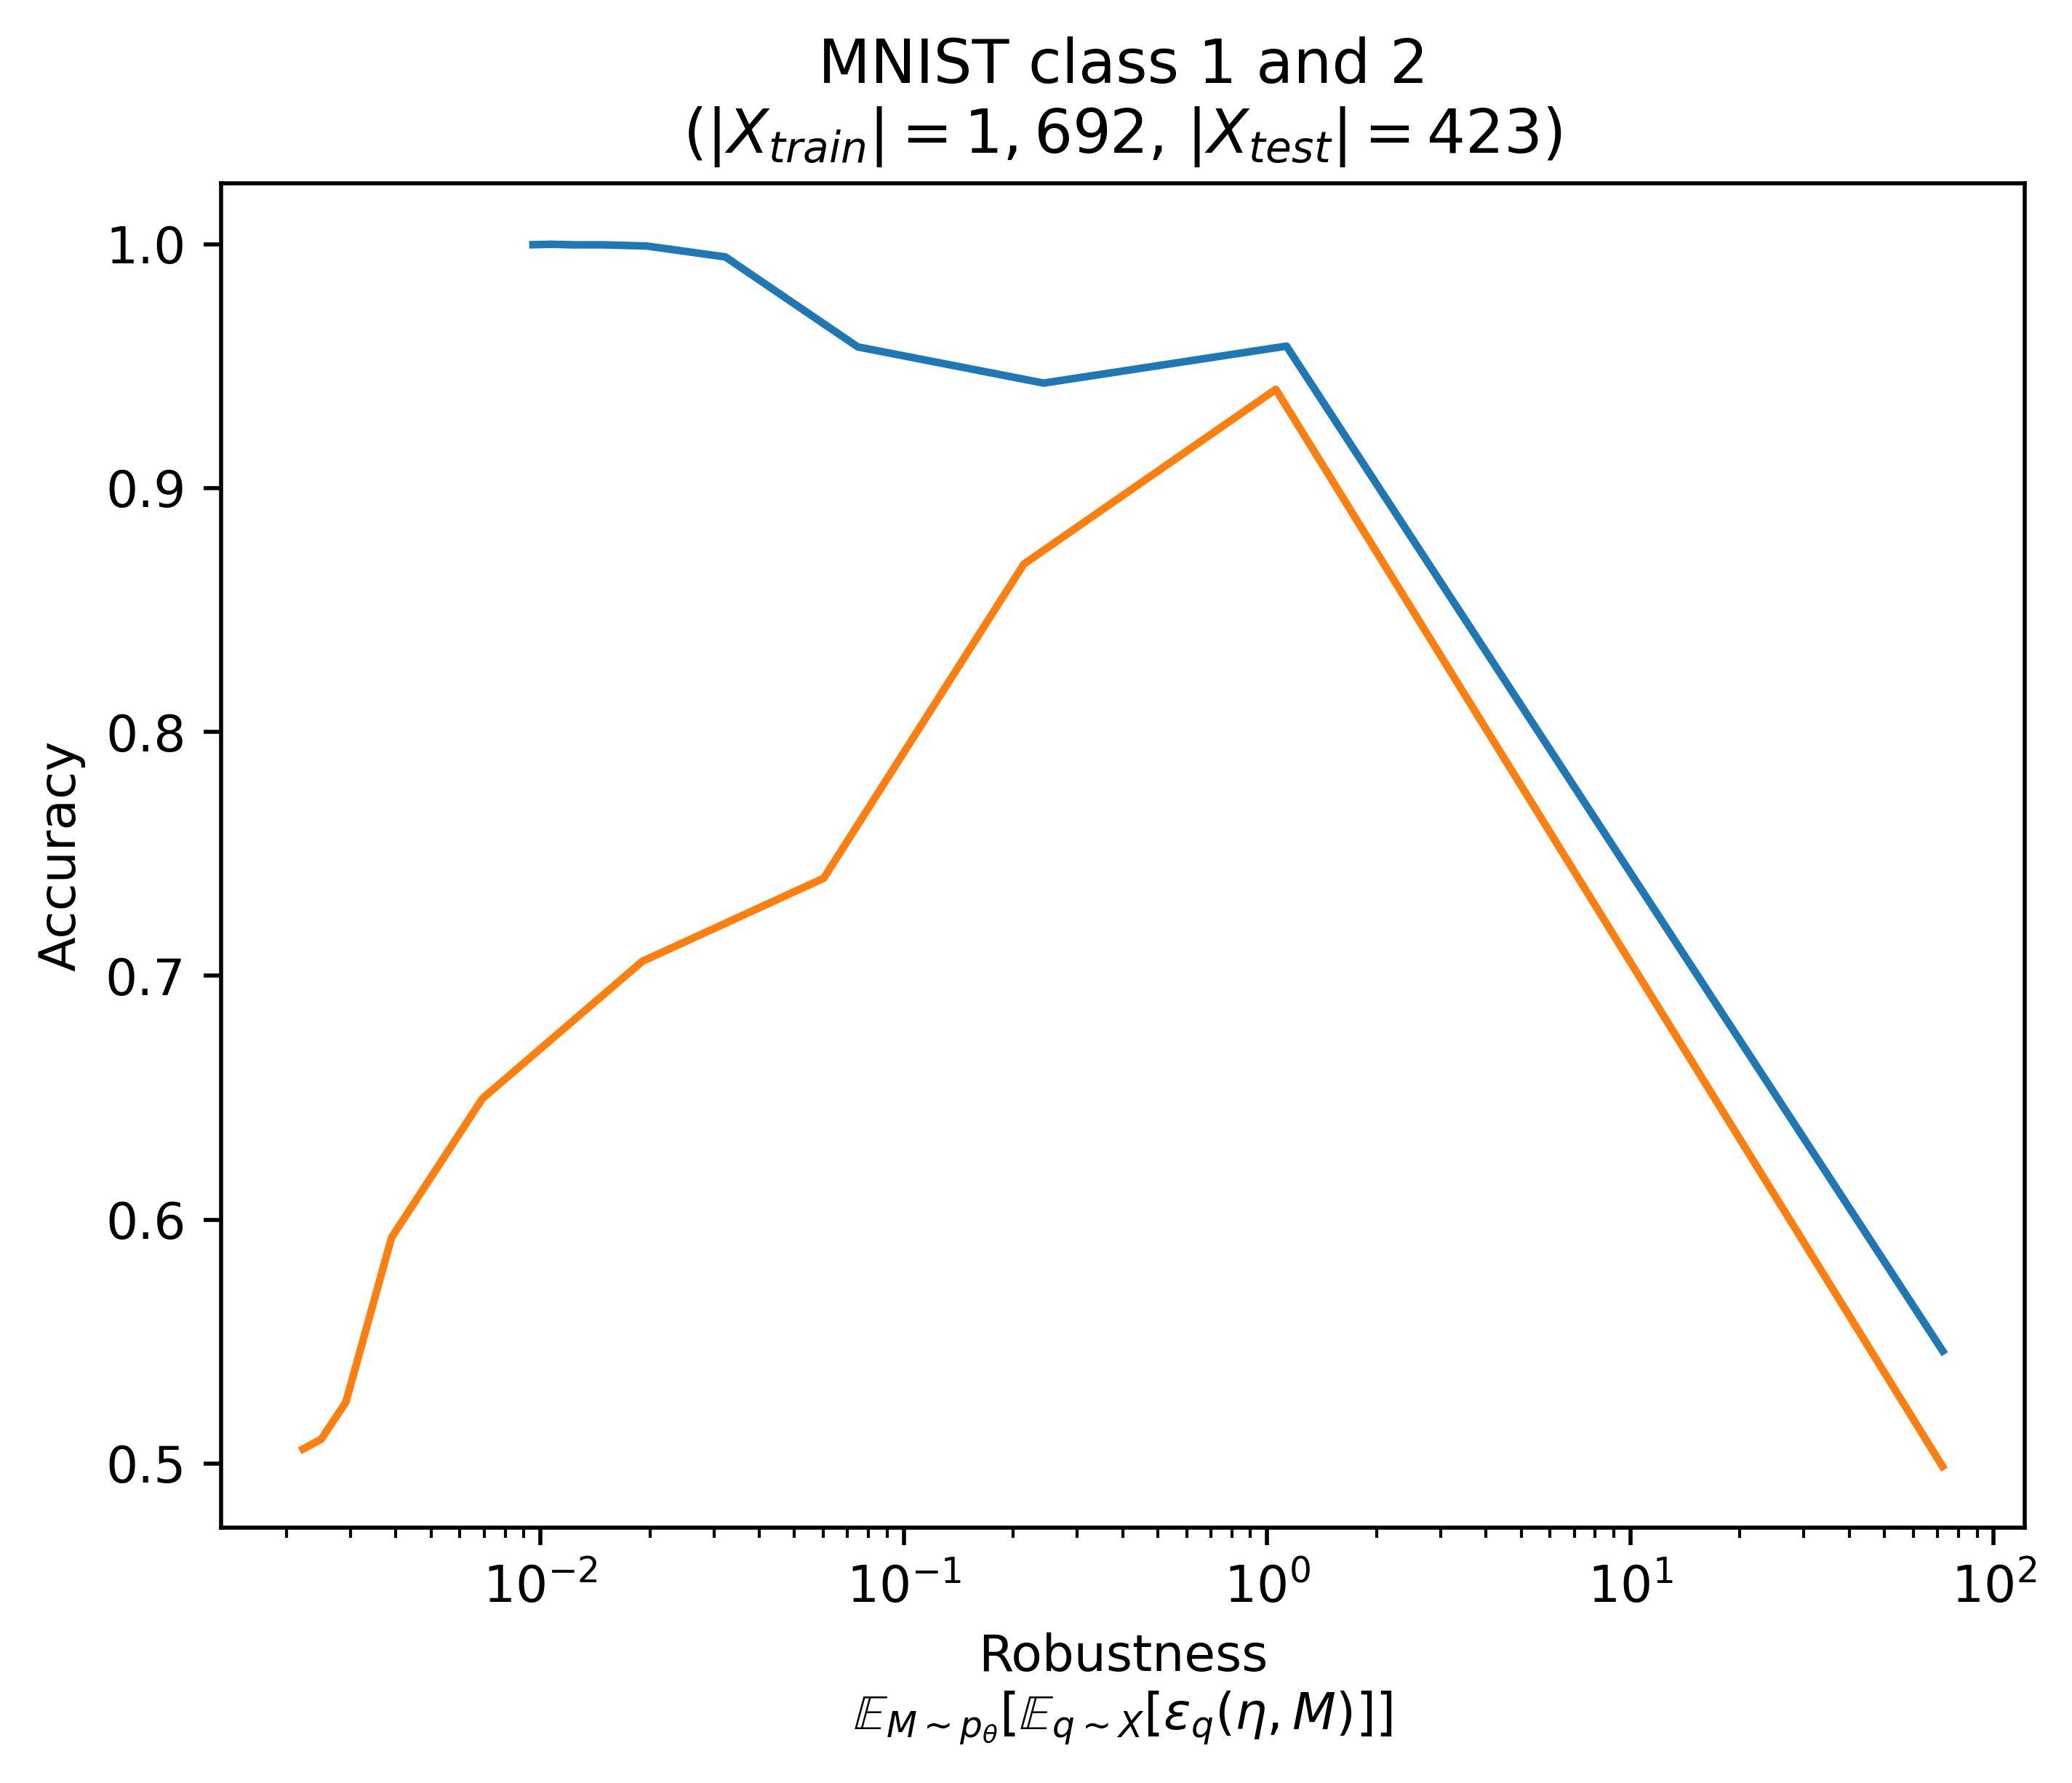

In [ ]:
thetas = torch.linspace(0.01, 2, 10)

mean_train_epsilons = []
mean_train_accs = []
mean_test_epsilons = []
mean_test_accs = []
for theta, result in zip(thetas, results):
  mean_train_epsilon = result[0].mean()
  mean_train_acc = result[1].mean()
  mean_test_epsilon = result[2].mean()
  mean_test_acc = result[3].mean()

  mean_train_epsilons.append(mean_train_epsilon.item())
  mean_train_accs.append(mean_train_acc.item())
  mean_test_epsilons.append(mean_test_epsilon.item())
  mean_test_accs.append(mean_test_acc.item())


train_trade_off = list(zip(mean_train_epsilons, mean_train_accs))
test_trade_off = list(zip(mean_test_epsilons, mean_test_accs))
train_trade_off.sort()
test_trade_off.sort()

plt.figure(dpi=500)
plt.plot(*zip(*train_trade_off), label='Train')
plt.plot(*zip(*test_trade_off), label='Test')
plt.xscale('log')
plt.xlabel('Robustness\n$\\mathbb{E}_{M\\sim p_\\theta}[\\mathbb{E}_{q\\sim X}[\\epsilon_q(\\eta , M)]]$')
plt.ylabel('Accuracy')
plt.title('MNIST class 1 and 2\n($|X_{train}| = 1,692$, $|X_{test}| = 423$)')
#plt.legend()
plt.show()

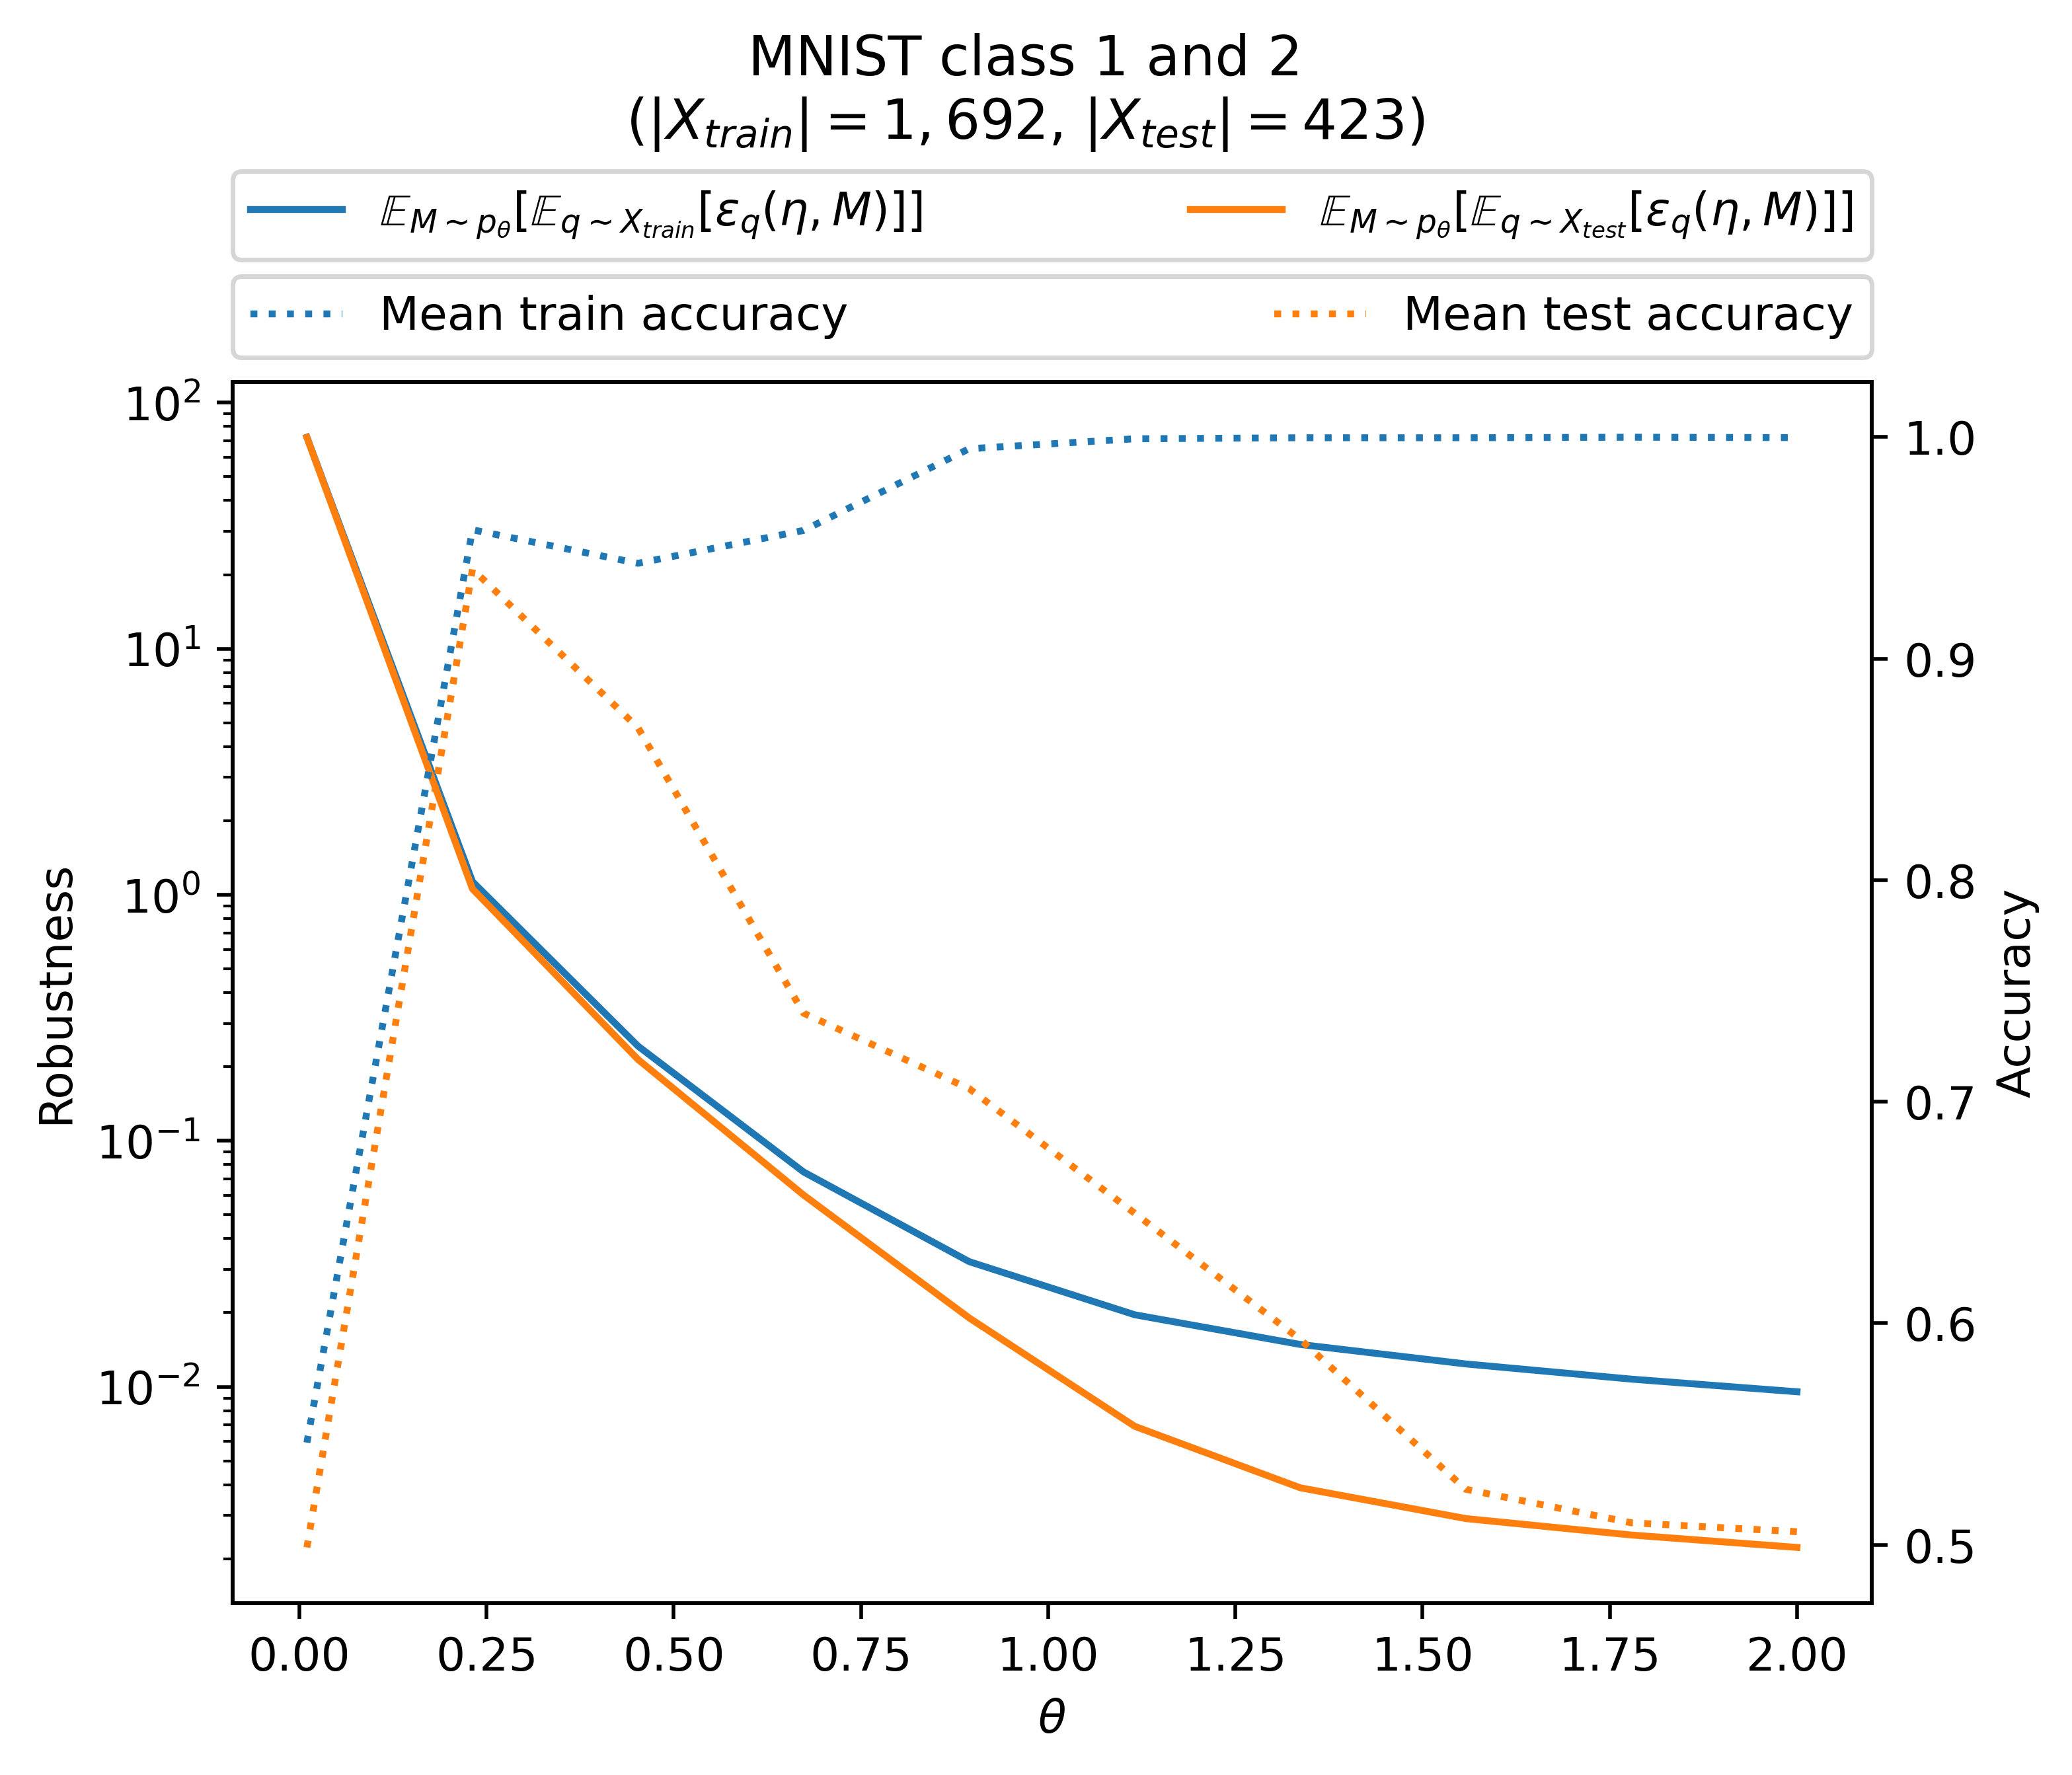

In [ ]:
mean_train_epsilons = []
mean_train_accs = []
mean_test_epsilons = []
mean_test_accs = []
for theta, result in zip(thetas, results):
  mean_train_epsilon = result[0].mean()
  mean_train_acc = result[1].mean()
  mean_test_epsilon = result[2].mean()
  mean_test_acc = result[3].mean()

  mean_train_epsilons.append(mean_train_epsilon.item())
  mean_train_accs.append(mean_train_acc.item())
  mean_test_epsilons.append(mean_test_epsilon.item())
  mean_test_accs.append(mean_test_acc.item())

fig, ax1 = plt.subplots(dpi=500)

ax2 = ax1.twinx()
ax1.set_yscale('log')
ax1.plot(thetas, mean_train_epsilons, label='$\\mathbb{E}_{M\\sim p_\\theta}[\\mathbb{E}_{q\\sim X_{train}}[\\epsilon_q(\\eta , M)]]$')
ax1.plot(thetas, mean_test_epsilons, label='$\\mathbb{E}_{M\\sim p_\\theta}[\\mathbb{E}_{q\\sim X_{test}}[\\epsilon_q(\\eta , M)]]$')

ax1.set_xlabel('$\\theta$')
ax1.set_ylabel('Robustness')
ax2.set_ylabel('Accuracy')

ax2.plot(thetas, mean_train_accs, linestyle='dotted', label='Mean train accuracy')
ax2.plot(thetas, mean_test_accs, linestyle='dotted', label='Mean test accuracy')

ax1.legend(bbox_to_anchor=(0, 1.1, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
ax2.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

#plt.legend()
fig.suptitle('MNIST class 1 and 2\n($|X_{train}| = 1,692$, $|X_{test}| = 423$)', y=1.1)
# 1692, 784]), torch.Size([423, 784]))
plt.show()

In [ ]:
thetas = torch.linspace(0.01, 2, 10)
noises = torch.linspace(0, 1, 100)
sample_size = 10

results = []

for theta in tqdm.tqdm(thetas):
  dists = torch.distributions.Normal(0.0, 1)
  samples = dists.sample(sample_shape=torch.Size((sample_size, dim, original_dim)))

  train_epsilons = []
  train_accuracies = []
  test_epsilons = []
  test_accuracies = []
  for sample in samples:
      M = sample*theta
      encoder = robustness_model.FHRREncoder(original_dim, dim, M=M)
      model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
      model.bundling(X_train, y_train) # X_train, y_train

      # model_ = model.detach()
      max_X, alpha, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=10000, show_pbar=False)

      train_ep3s = torch.stack([model.get_eps(x, alpha) for x in X_train])
      train_epsilons.append(train_ep3s.mean())

      test_ep3s = torch.stack([model.get_eps(x, alpha) for x in X_test])
      test_epsilons.append(test_ep3s.mean())

      train_accuracies_by_noise = []
      test_accuracies_by_noise = []

      for noise in noises:
        nvec = torch.empty_like(X_train[0]).normal_(0, 1)
        nvec *= noise / nvec.norm() # Noise on queries

        train_acc = (y_train == model.predict(X_train + nvec)).sum() / len(y_train)
        train_accuracies_by_noise.append(train_acc)
        
        test_acc = (y_test == model.predict(X_test + nvec)).sum() / len(y_test)
        test_accuracies_by_noise.append(test_acc)
      
      train_accuracies.append(torch.stack(train_accuracies_by_noise))
      test_accuracies.append(torch.stack(test_accuracies_by_noise))

  train_epsilons = torch.stack(train_epsilons)
  train_accuracies = torch.stack(train_accuracies)
  test_epsilons = torch.stack(test_epsilons)
  test_accuracies = torch.stack(test_accuracies)

  print(theta, train_epsilons.mean(), train_accuracies.mean(), test_epsilons.mean(), test_accuracies.mean())

  results.append((
      train_epsilons, train_accuracies, test_epsilons, test_accuracies
  ))

 10%|█         | 1/10 [26:36<3:59:32, 1596.92s/it]

tensor(0.0100) tensor(72.4286) tensor(0.5461) tensor(72.3023) tensor(0.4988)


 20%|██        | 2/10 [53:27<3:33:59, 1604.95s/it]

tensor(0.2311) tensor(1.1312) tensor(0.9589) tensor(1.0570) tensor(0.9419)


 30%|███       | 3/10 [1:17:23<2:58:13, 1527.58s/it]

tensor(0.4522) tensor(0.2427) tensor(0.9398) tensor(0.2140) tensor(0.8696)


 40%|████      | 4/10 [1:41:21<2:29:14, 1492.37s/it]

tensor(0.6733) tensor(0.0747) tensor(0.9509) tensor(0.0600) tensor(0.7467)


 50%|█████     | 5/10 [2:05:24<2:02:52, 1474.58s/it]

tensor(0.8944) tensor(0.0322) tensor(0.9880) tensor(0.0190) tensor(0.7006)


 60%|██████    | 6/10 [2:29:39<1:37:51, 1467.92s/it]

tensor(1.1156) tensor(0.0196) tensor(0.9924) tensor(0.0070) tensor(0.6494)


 70%|███████   | 7/10 [2:53:49<1:13:06, 1462.16s/it]

tensor(1.3367) tensor(0.0149) tensor(0.9866) tensor(0.0038) tensor(0.5632)


 80%|████████  | 8/10 [3:17:53<48:32, 1456.19s/it]  

tensor(1.5578) tensor(0.0124) tensor(0.9724) tensor(0.0028) tensor(0.5235)


 90%|█████████ | 9/10 [3:41:51<24:10, 1450.57s/it]

tensor(1.7789) tensor(0.0107) tensor(0.9506) tensor(0.0026) tensor(0.5070)


100%|██████████| 10/10 [4:05:48<00:00, 1474.82s/it]

tensor(2.) tensor(0.0095) tensor(0.9245) tensor(0.0022) tensor(0.5064)


In [ ]:
results

[(tensor([72.2025, 72.4172, 72.5691, 72.5054, 72.3628, 72.4238, 72.5122, 72.3466,
          72.3600, 72.5863]),
  tensor([[0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
           0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
           0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
           0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
           0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
           0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
           0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
           0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
           0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
           0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,
           0.5461, 0.5461, 0.5461, 0.5461, 0.5461, 0.5461,

In [ ]:
results[9][1].mean(axis=0)

tensor([0.9998, 0.9998, 0.9998, 0.9996, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998,
        0.9996, 0.9995, 0.9995, 0.9996, 0.9993, 0.9995, 0.9995, 0.9995, 0.9995,
        0.9992, 0.9994, 0.9993, 0.9993, 0.9991, 0.9989, 0.9986, 0.9989, 0.9986,
        0.9983, 0.9981, 0.9977, 0.9975, 0.9971, 0.9974, 0.9969, 0.9971, 0.9962,
        0.9961, 0.9959, 0.9951, 0.9940, 0.9927, 0.9936, 0.9915, 0.9910, 0.9903,
        0.9891, 0.9860, 0.9853, 0.9866, 0.9829, 0.9820, 0.9791, 0.9733, 0.9751,
        0.9724, 0.9674, 0.9665, 0.9627, 0.9590, 0.9530, 0.9508, 0.9454, 0.9414,
        0.9384, 0.9319, 0.9285, 0.9181, 0.9149, 0.9100, 0.9001, 0.8928, 0.8908,
        0.8811, 0.8770, 0.8720, 0.8617, 0.8558, 0.8478, 0.8404, 0.8336, 0.8212,
        0.8153, 0.8097, 0.8012, 0.7910, 0.7865, 0.7784, 0.7801, 0.7610, 0.7565,
        0.7416, 0.7316, 0.7272, 0.7273, 0.7111, 0.6992, 0.7008, 0.6908, 0.6885,
        0.6784])

[72.42859649658203, 1.131239891052246, 0.24275000393390656, 0.07464000582695007, 0.032249994575977325, 0.01964000053703785, 0.014870000071823597, 0.01242000050842762, 0.01075000036507845, 0.009549999609589577]
[72.30229187011719, 1.0570499897003174, 0.21398000419139862, 0.060030002146959305, 0.019050000235438347, 0.007020000368356705, 0.0038299995940178633, 0.0028200000524520874, 0.0025599999353289604, 0.0022499999031424522]


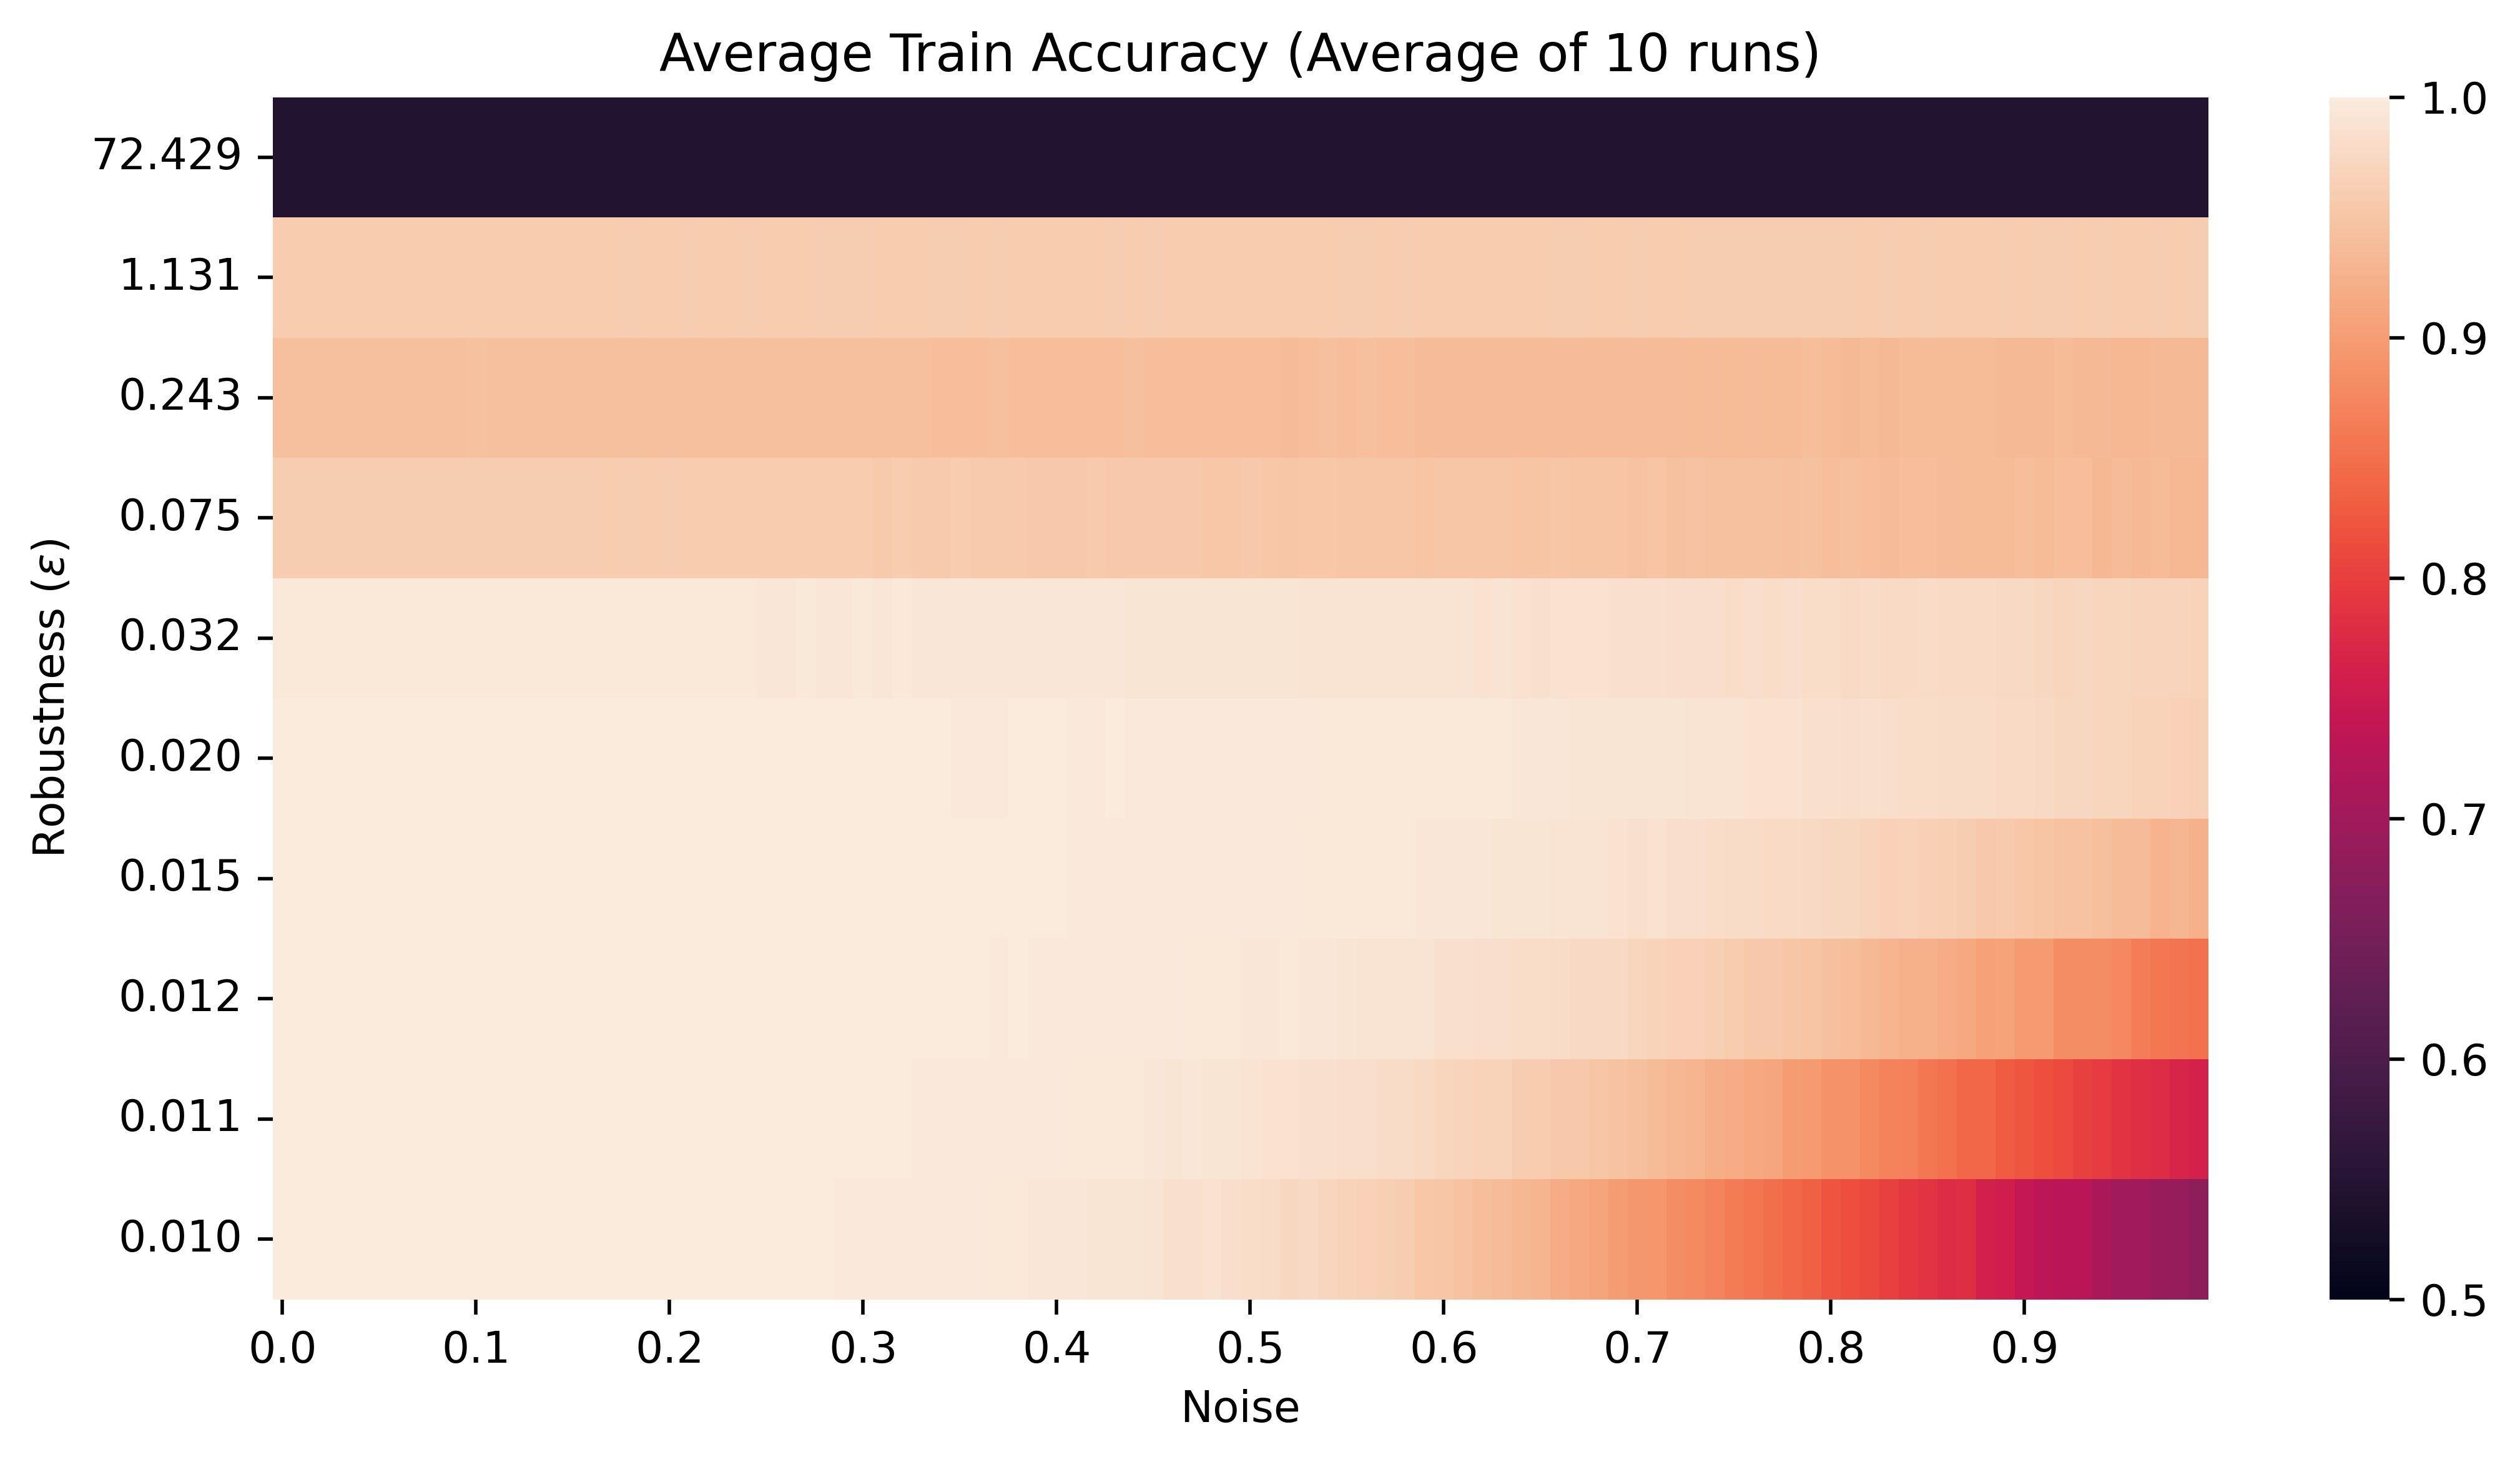

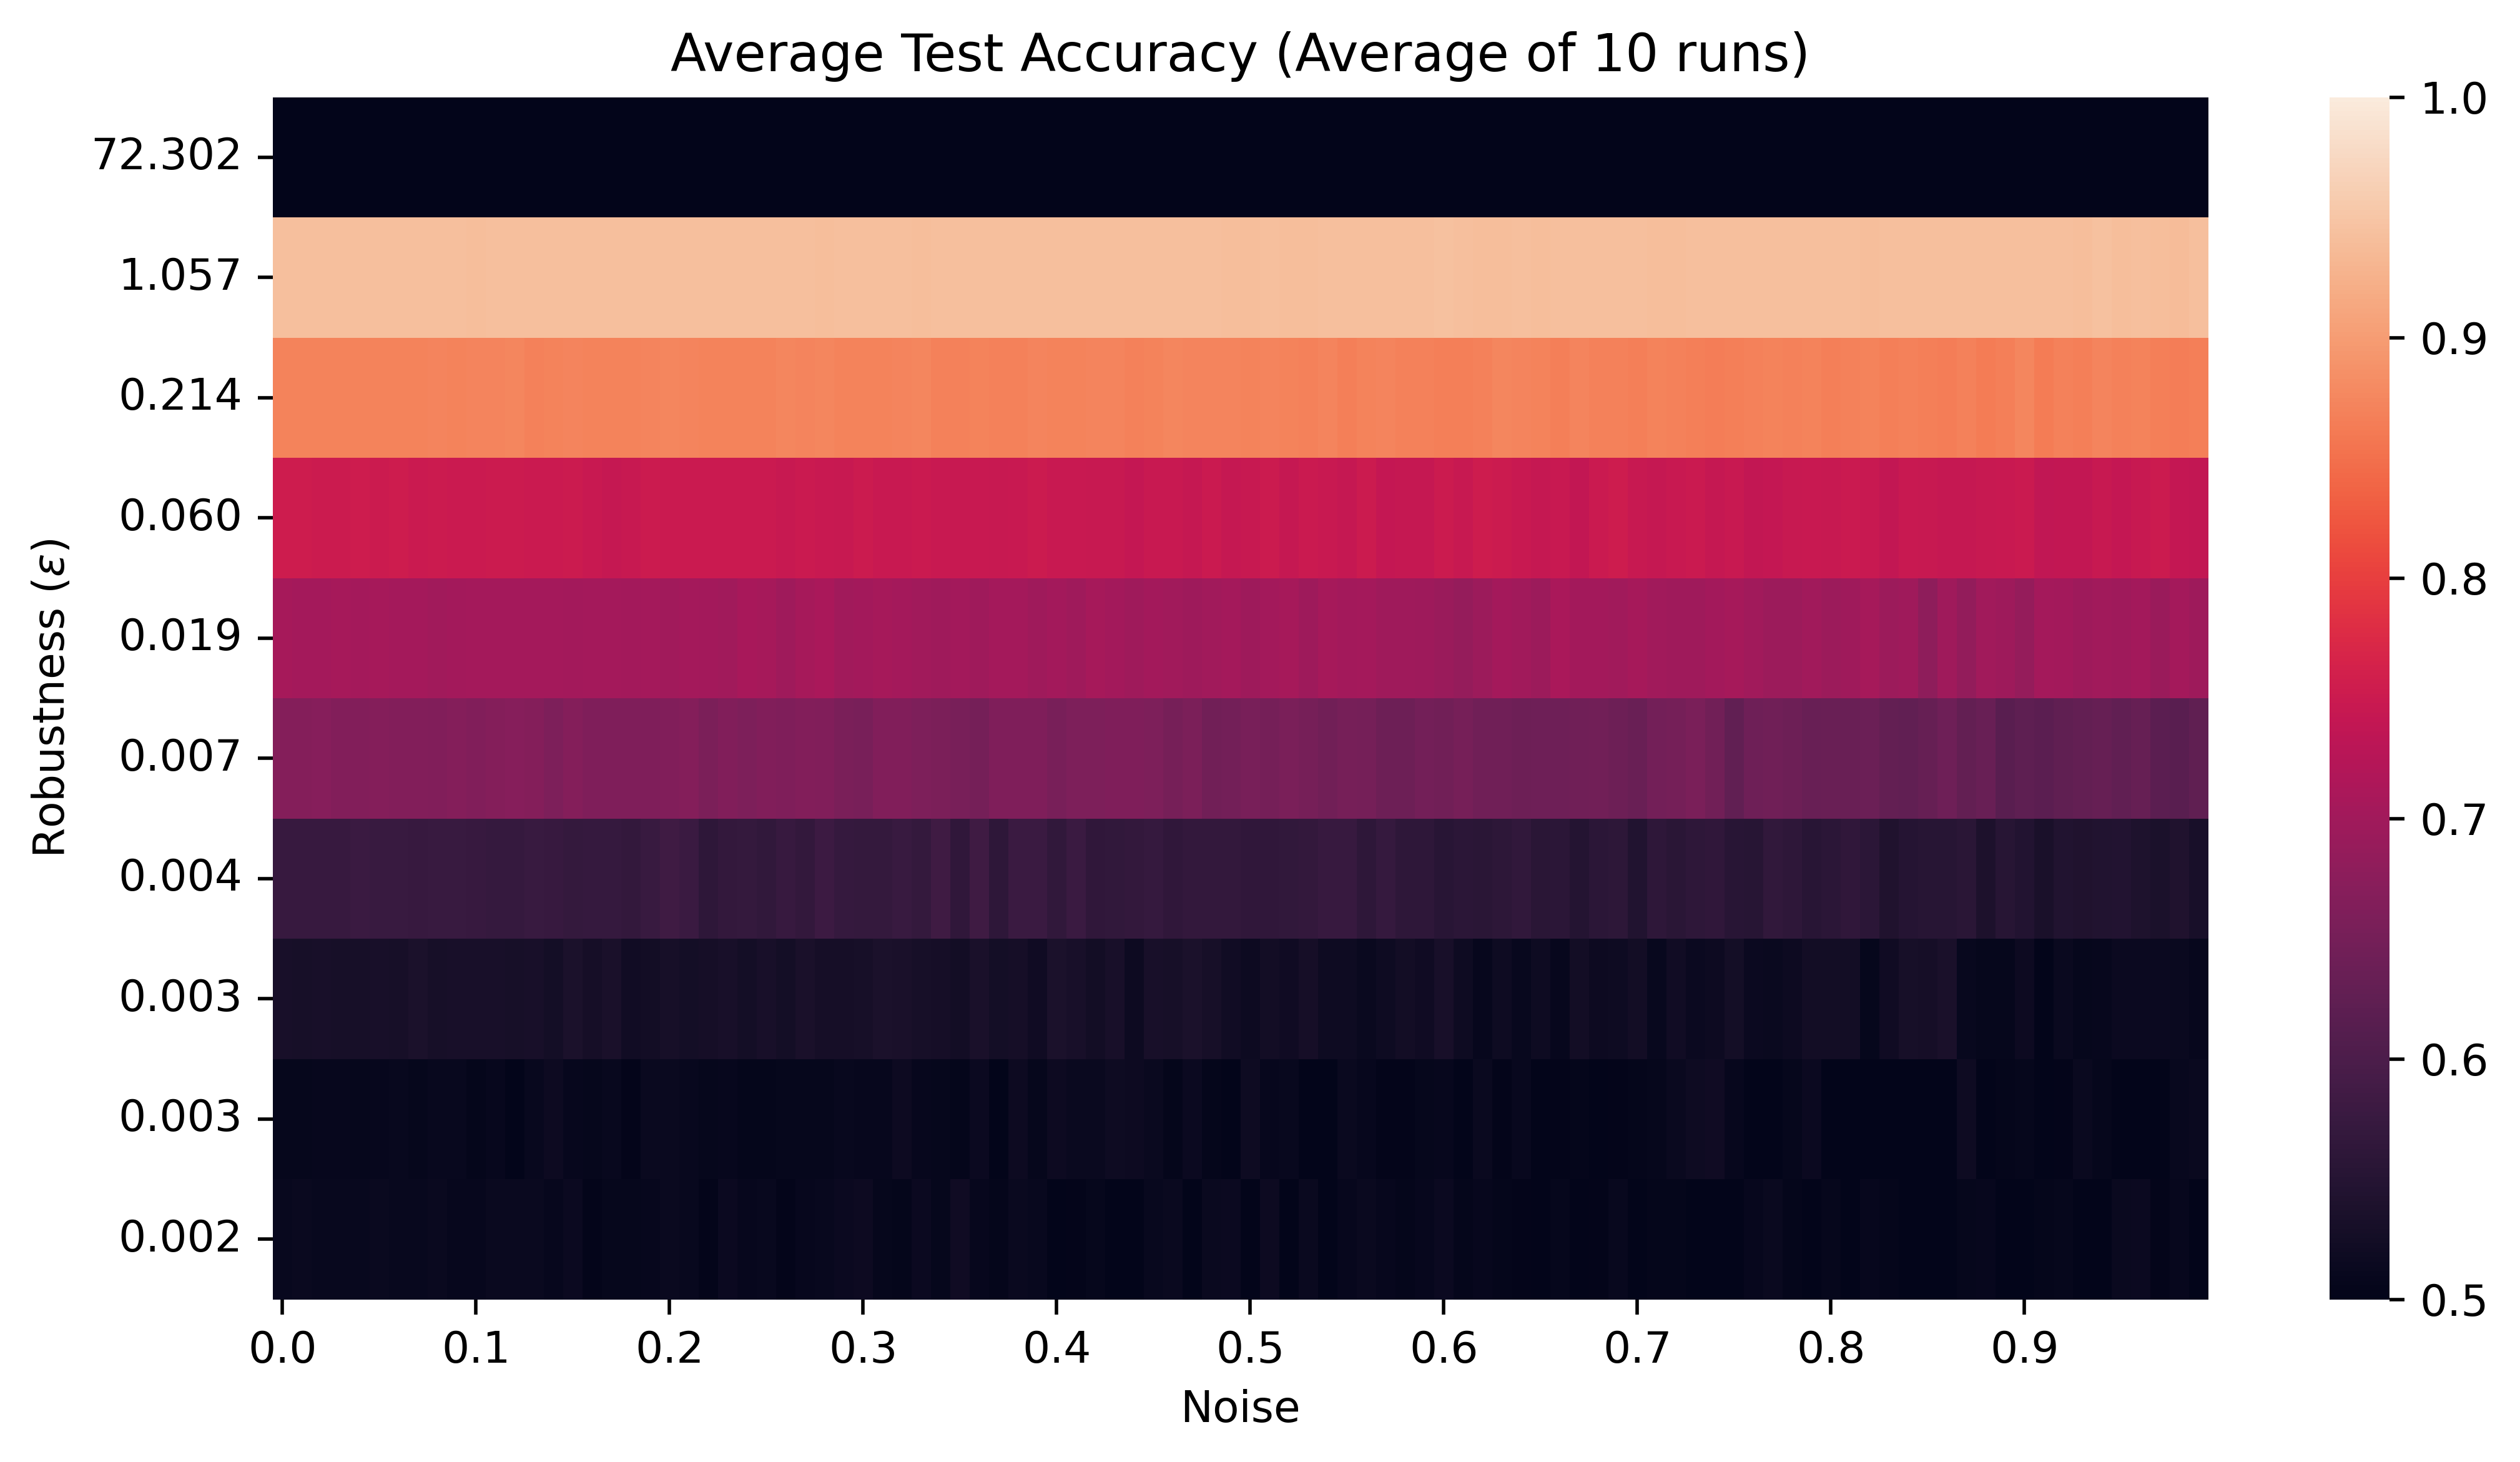

In [ ]:
import seaborn as sns

avg_train_robustnesses, avg_train_accs = [], []
avg_test_robustnesses, avg_test_accs = [], []
for train_epsilons, train_accuracies, test_epsilons, test_accuracies in results:
  avg_train_robustness = train_epsilons.mean()
  avg_train_acc = train_accuracies.mean(axis=0)

  avg_test_robustness = test_epsilons.mean()
  avg_test_acc = test_accuracies.mean(axis=0)

  avg_train_robustnesses.append(avg_train_robustness.item())
  avg_train_accs.append(avg_train_acc)
  avg_test_robustnesses.append(avg_test_robustness.item())
  avg_test_accs.append(avg_test_acc)

print(avg_train_robustnesses)
print(avg_test_robustnesses)

plt.figure(figsize=(10, 5), dpi=500)
data = np.zeros((len(avg_train_robustnesses), len(noises)))
for epsilon_idx, epsilon in enumerate(avg_train_robustnesses):
  for noise_idx, acc in enumerate(avg_train_accs[epsilon_idx]):
    data[epsilon_idx, noise_idx] = acc

ax = sns.heatmap(data[::,:], linewidth=0., cmap='rocket', square=False, vmin=0.5, vmax=1.0) # 
plt.xlabel('Noise')
plt.xticks([i + 0.5 for i in range(len(noises))][::10], [f'{x.item():.1f}' for x in noises[::10]], ) # rotation=90
plt.ylabel('Robustness ($\epsilon$)')
plt.yticks([i + 0.5 for i in range(len(avg_train_robustnesses))], [f'{eps:.3f}' for eps in avg_train_robustnesses][::], rotation=0)
plt.title('Average Train Accuracy (Average of 10 runs)')
plt.show()

plt.figure(figsize=(10, 5), dpi=500)
data = np.zeros((len(avg_test_robustnesses), len(noises)))
for epsilon_idx, epsilon in enumerate(avg_test_robustnesses):
  for noise_idx, acc in enumerate(avg_test_accs[epsilon_idx]):
    data[epsilon_idx, noise_idx] = acc

ax = sns.heatmap(data[::,:], linewidth=0., cmap='rocket', square=False, vmin=0.5, vmax=1.0) # vmin=0.5, vmax=1.0
plt.xlabel('Noise')
plt.xticks([i + 0.5 for i in range(len(noises))][::10], [f'{x.item():.1f}' for x in noises[::10]], ) # rotation=90
plt.ylabel('Robustness ($\epsilon$)')
plt.yticks([i + 0.5 for i in range(len(avg_test_robustnesses))], [f'{eps:.3f}' for eps in avg_test_robustnesses][::], rotation=0)
plt.title('Average Test Accuracy (Average of 10 runs)')
plt.show()

[72.42859649658203, 1.131239891052246, 0.24275000393390656, 0.07464000582695007, 0.032249994575977325, 0.01964000053703785, 0.014870000071823597, 0.01242000050842762, 0.01075000036507845, 0.009549999609589577]
[72.30229187011719, 1.0570499897003174, 0.21398000419139862, 0.060030002146959305, 0.019050000235438347, 0.007020000368356705, 0.0038299995940178633, 0.0028200000524520874, 0.0025599999353289604, 0.0022499999031424522]


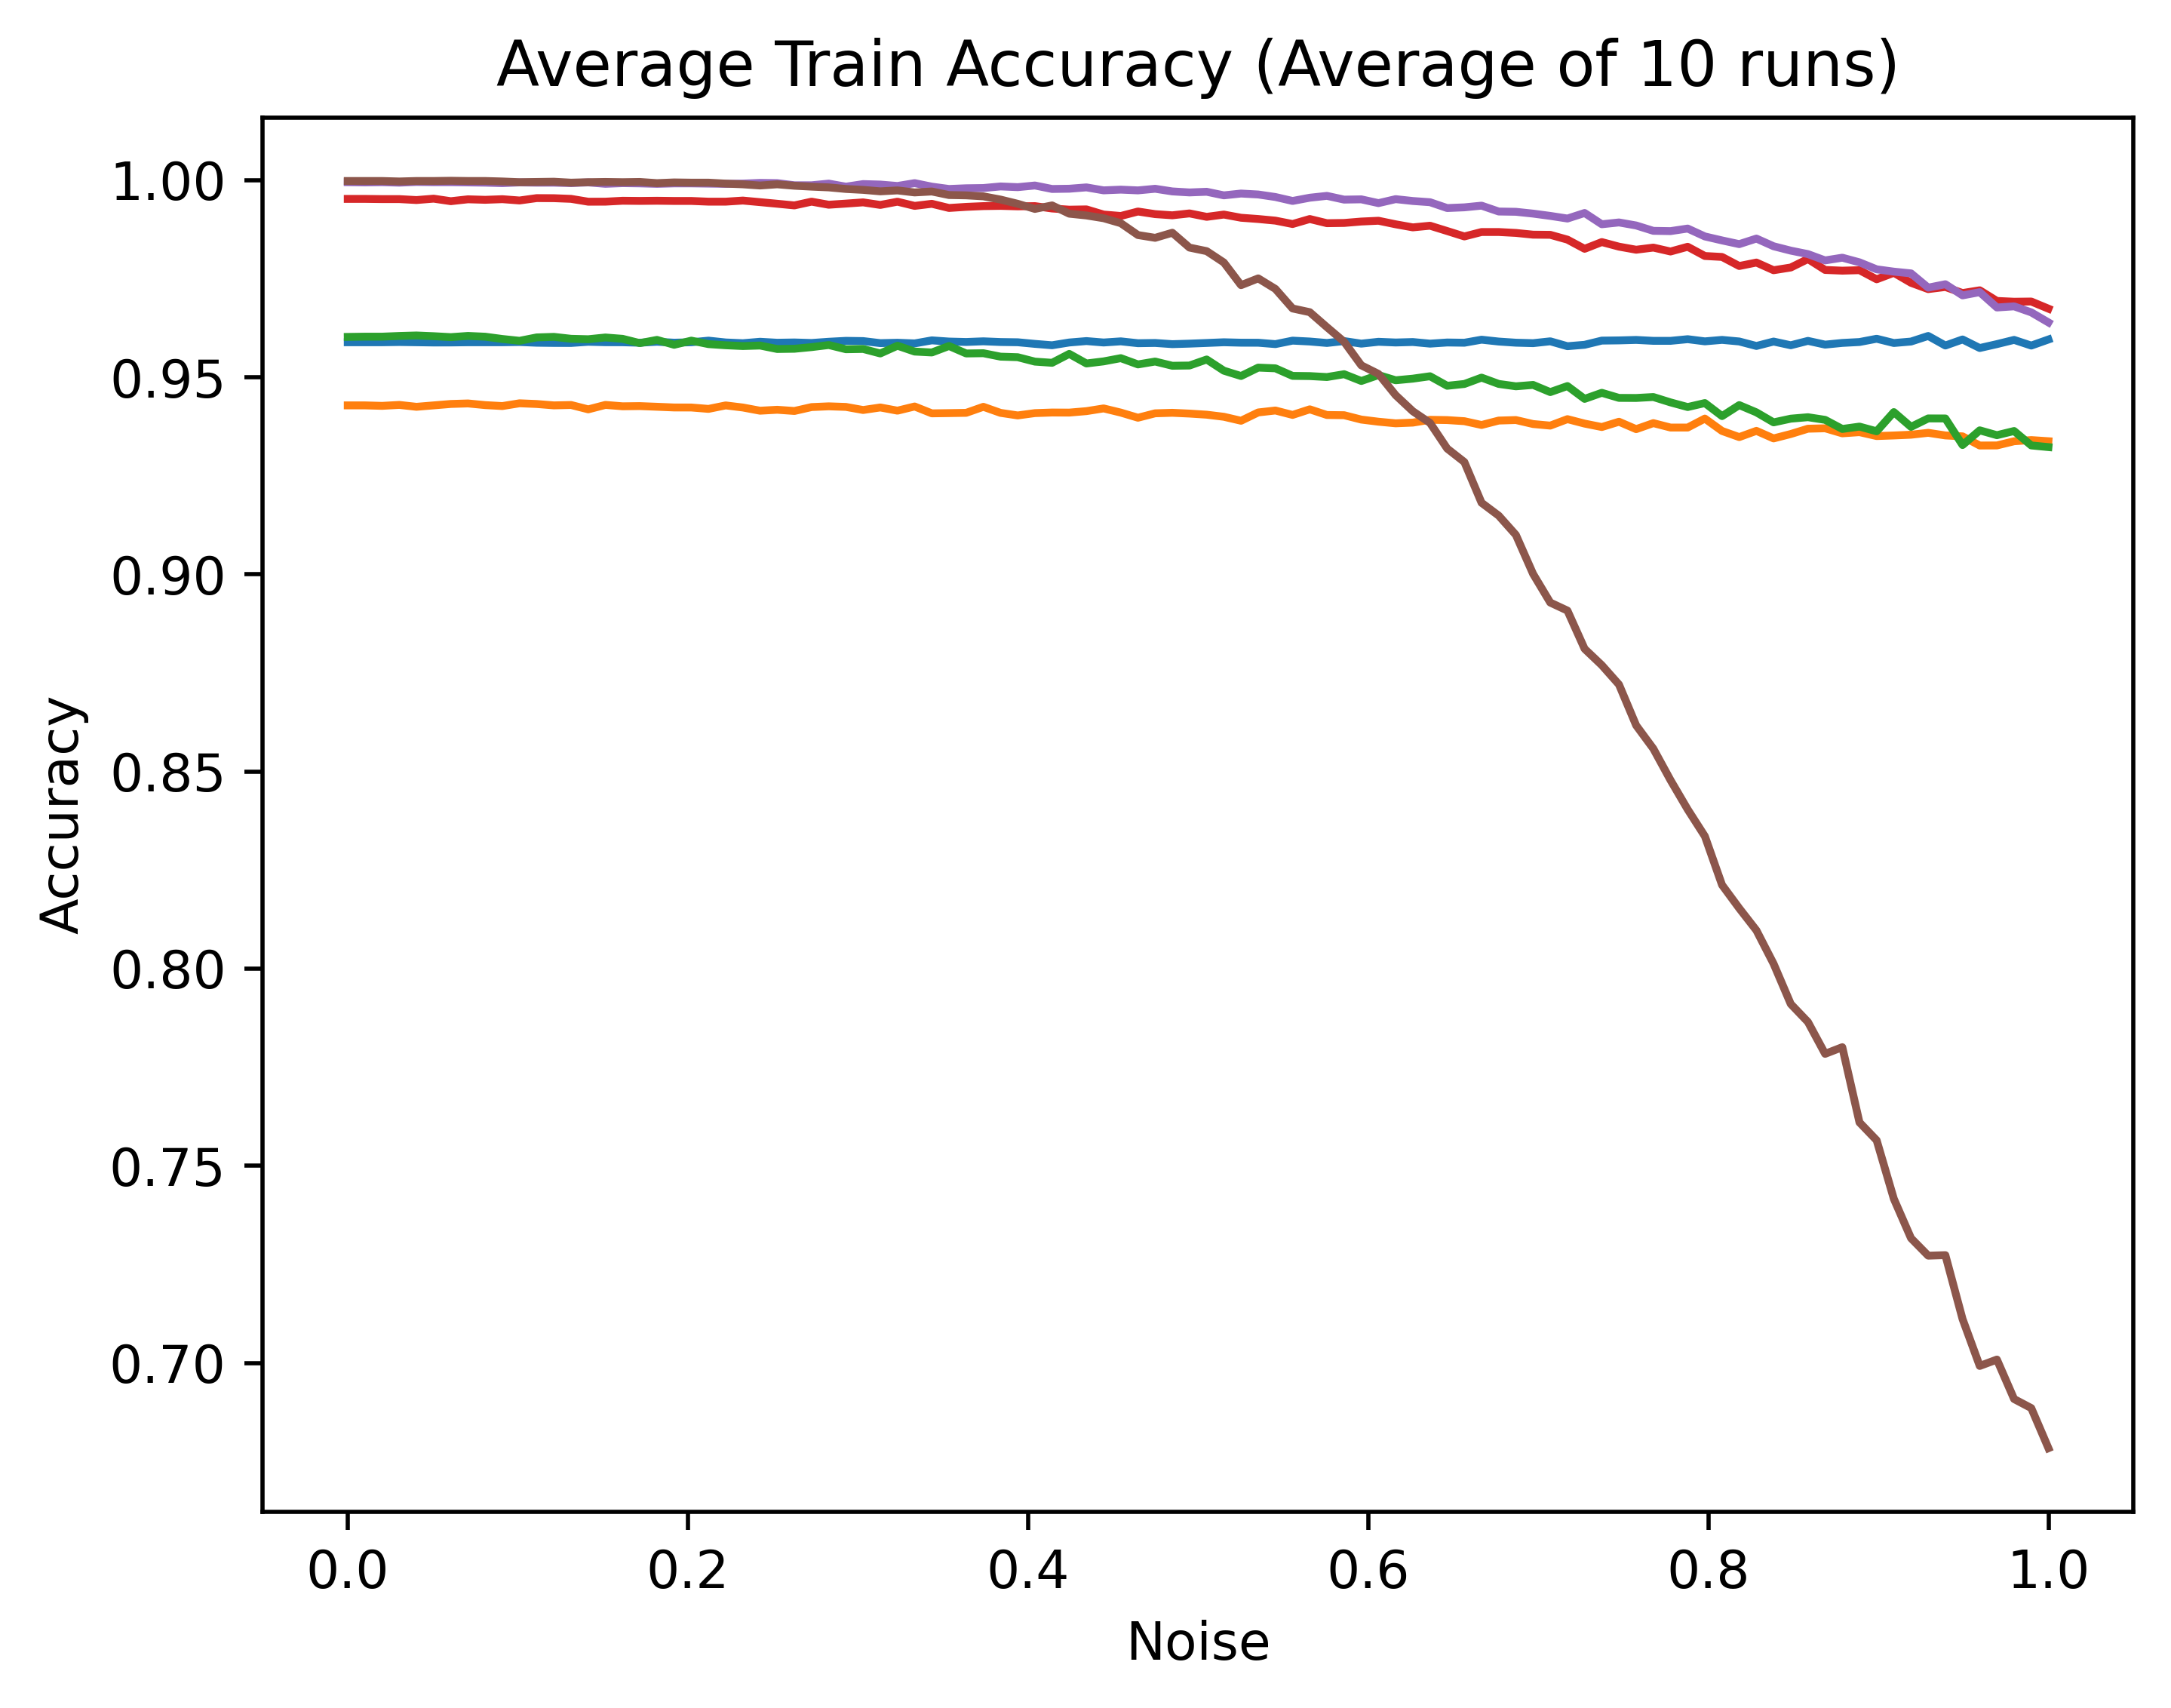

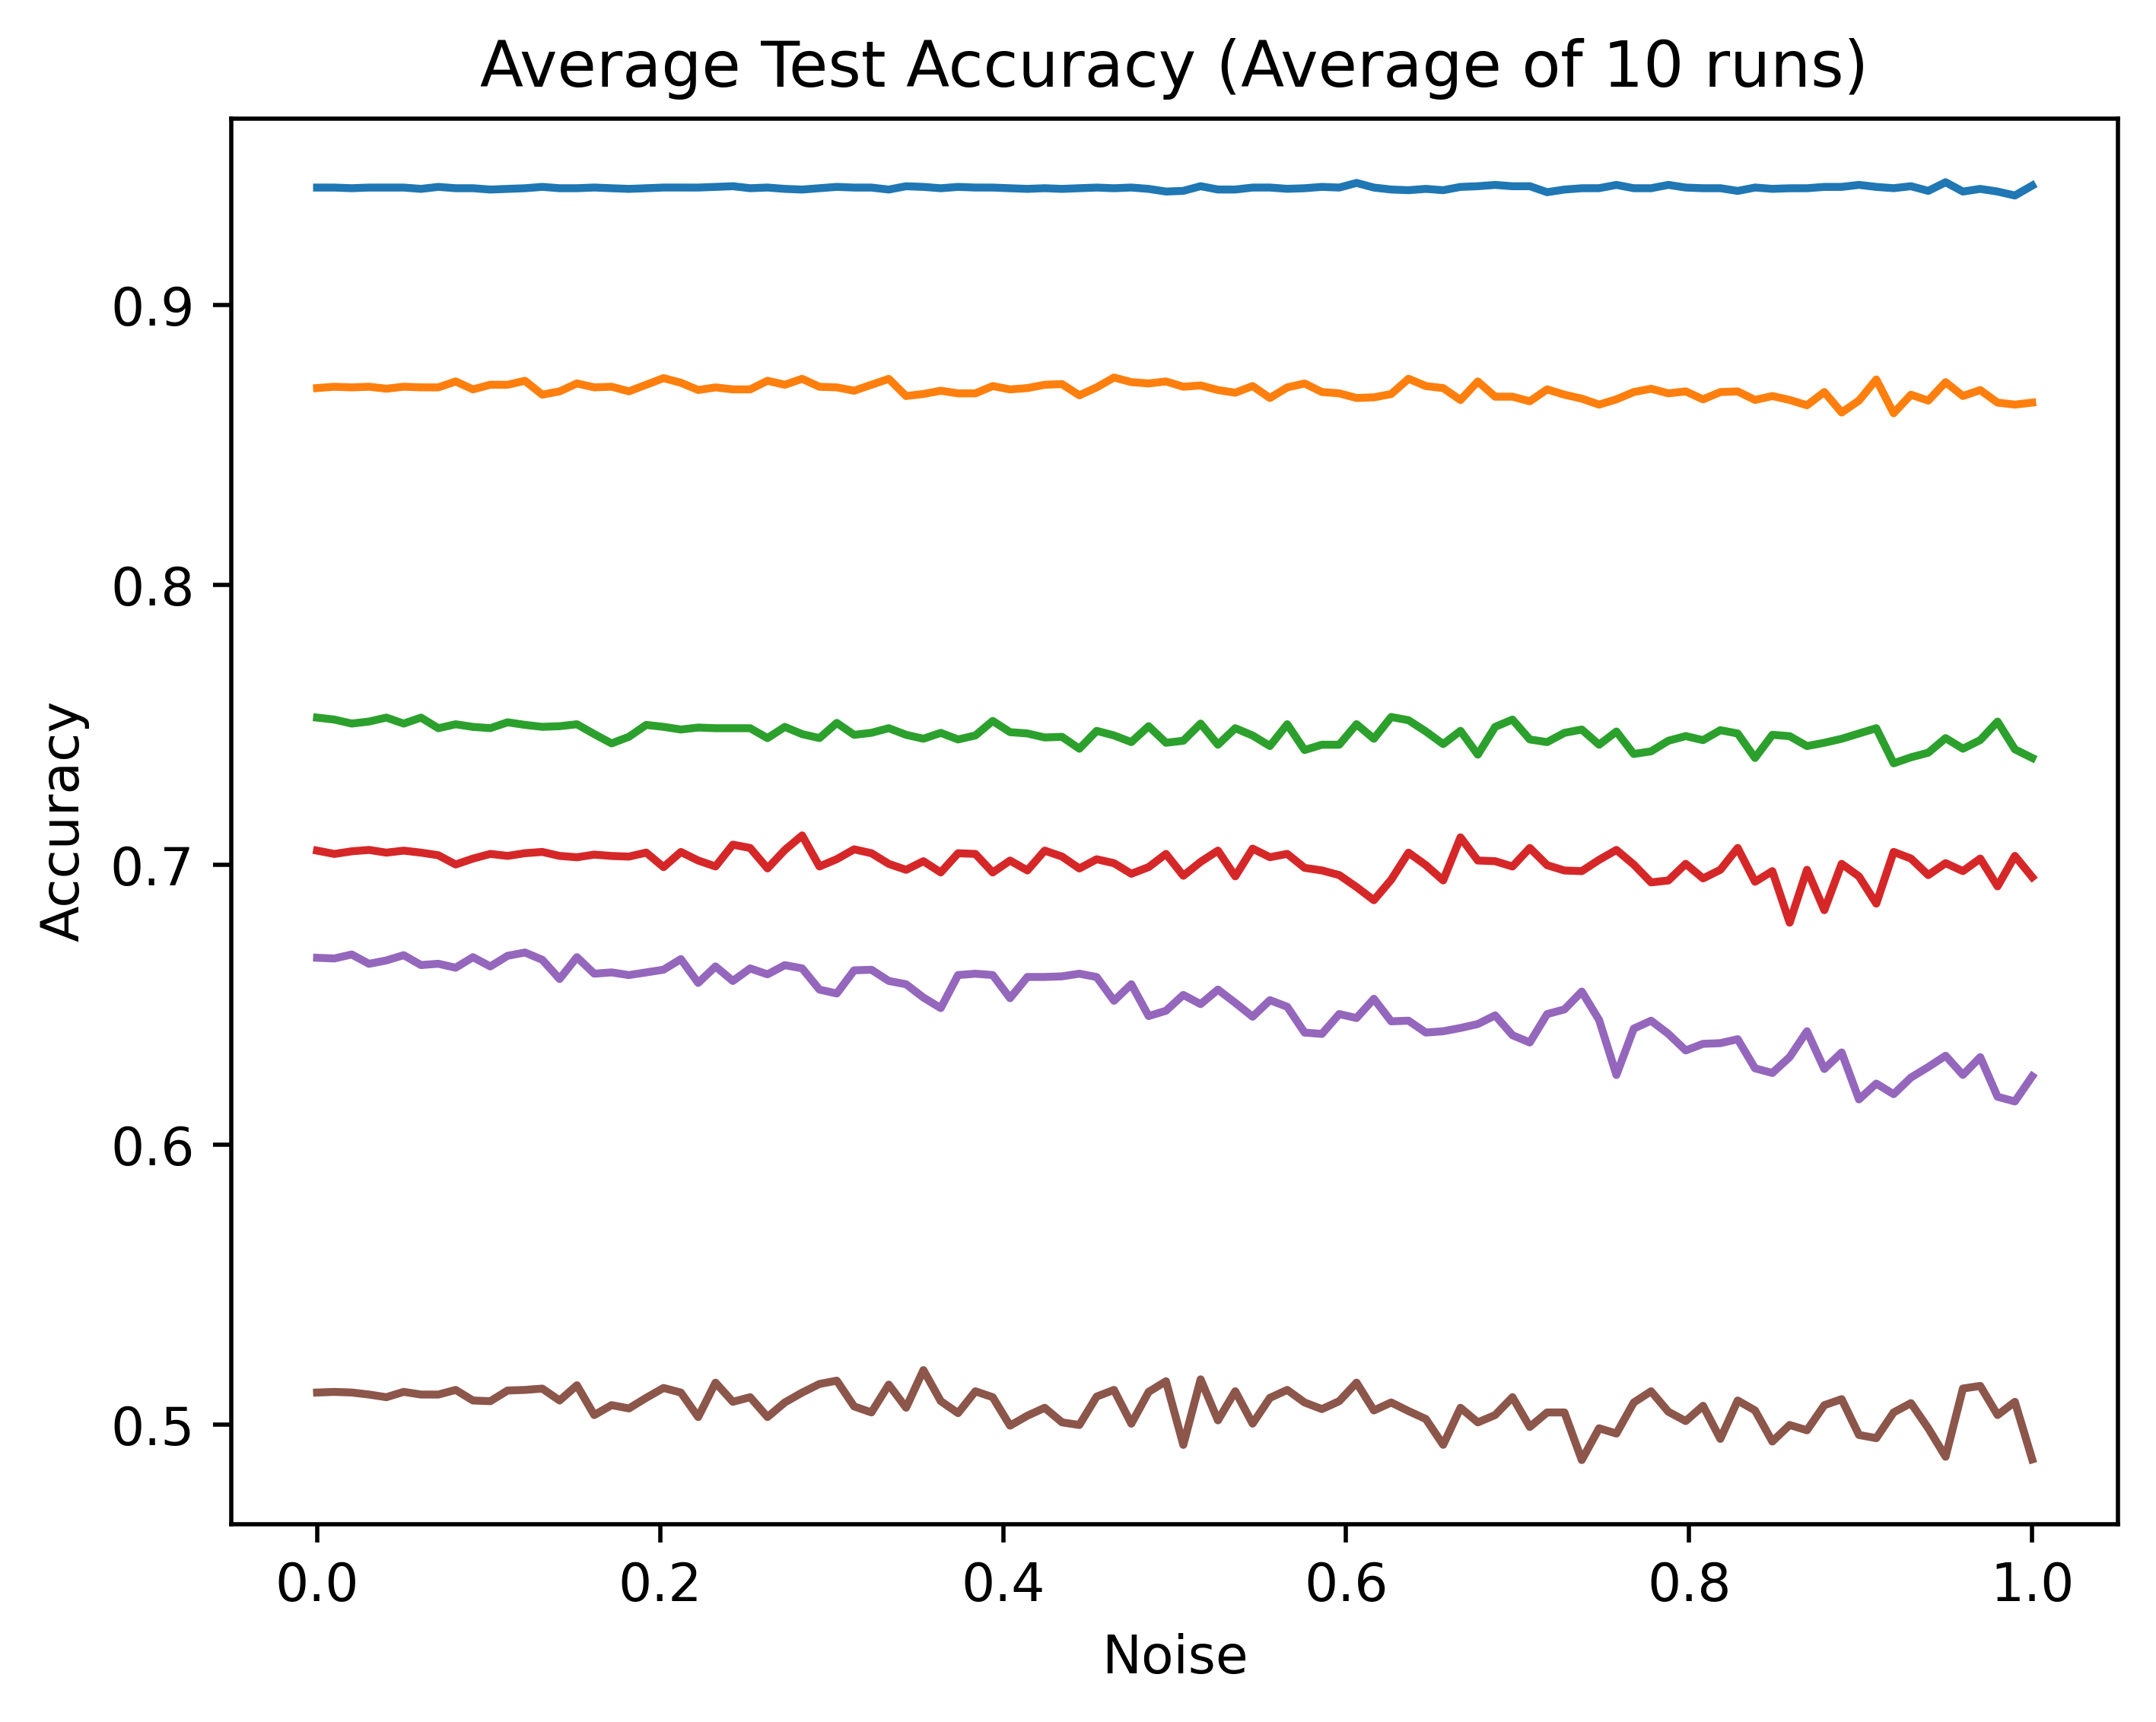

In [ ]:
avg_train_robustnesses, avg_train_accs = [], []
avg_test_robustnesses, avg_test_accs = [], []
for train_epsilons, train_accuracies, test_epsilons, test_accuracies in results:
  avg_train_robustness = train_epsilons.mean()
  avg_train_acc = train_accuracies.mean(axis=0)

  avg_test_robustness = test_epsilons.mean()
  avg_test_acc = test_accuracies.mean(axis=0)

  avg_train_robustnesses.append(avg_train_robustness.item())
  avg_train_accs.append(avg_train_acc)
  avg_test_robustnesses.append(avg_test_robustness.item())
  avg_test_accs.append(avg_test_acc)

print(avg_train_robustnesses)
print(avg_test_robustnesses)

plt.figure(dpi=500)
plt.plot(noises, avg_train_accs[1], label=f'Avg Epsilon={avg_train_robustnesses[1]:.3f}')
plt.plot(noises, avg_train_accs[2], label=f'Avg Epsilon={avg_train_robustnesses[2]:.3f}')
plt.plot(noises, avg_train_accs[3], label=f'Avg Epsilon={avg_train_robustnesses[3]:.3f}')
plt.plot(noises, avg_train_accs[4], label=f'Avg Epsilon={avg_train_robustnesses[4]:.3f}')
plt.plot(noises, avg_train_accs[5], label=f'Avg Epsilon={avg_train_robustnesses[5]:.3f}')
plt.plot(noises, avg_train_accs[-1], label=f'Avg Epsilon={avg_train_robustnesses[-1]:.3f}')
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.title('Average Train Accuracy (Average of 10 runs)')
#plt.legend()
plt.show()

plt.figure(dpi=500)
plt.plot(noises, avg_test_accs[1], label=f'Avg Epsilon={avg_test_robustnesses[1]:.3f}')
plt.plot(noises, avg_test_accs[2], label=f'Avg Epsilon={avg_test_robustnesses[2]:.3f}')
plt.plot(noises, avg_test_accs[3], label=f'Avg Epsilon={avg_test_robustnesses[3]:.3f}')
plt.plot(noises, avg_test_accs[4], label=f'Avg Epsilon={avg_test_robustnesses[4]:.3f}')
plt.plot(noises, avg_test_accs[5], label=f'Avg Epsilon={avg_test_robustnesses[5]:.3f}')
plt.plot(noises, avg_test_accs[-1], label=f'Avg Epsilon={avg_test_robustnesses[-1]:.3f}')
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.title('Average Test Accuracy (Average of 10 runs)')
#plt.legend()
plt.show()

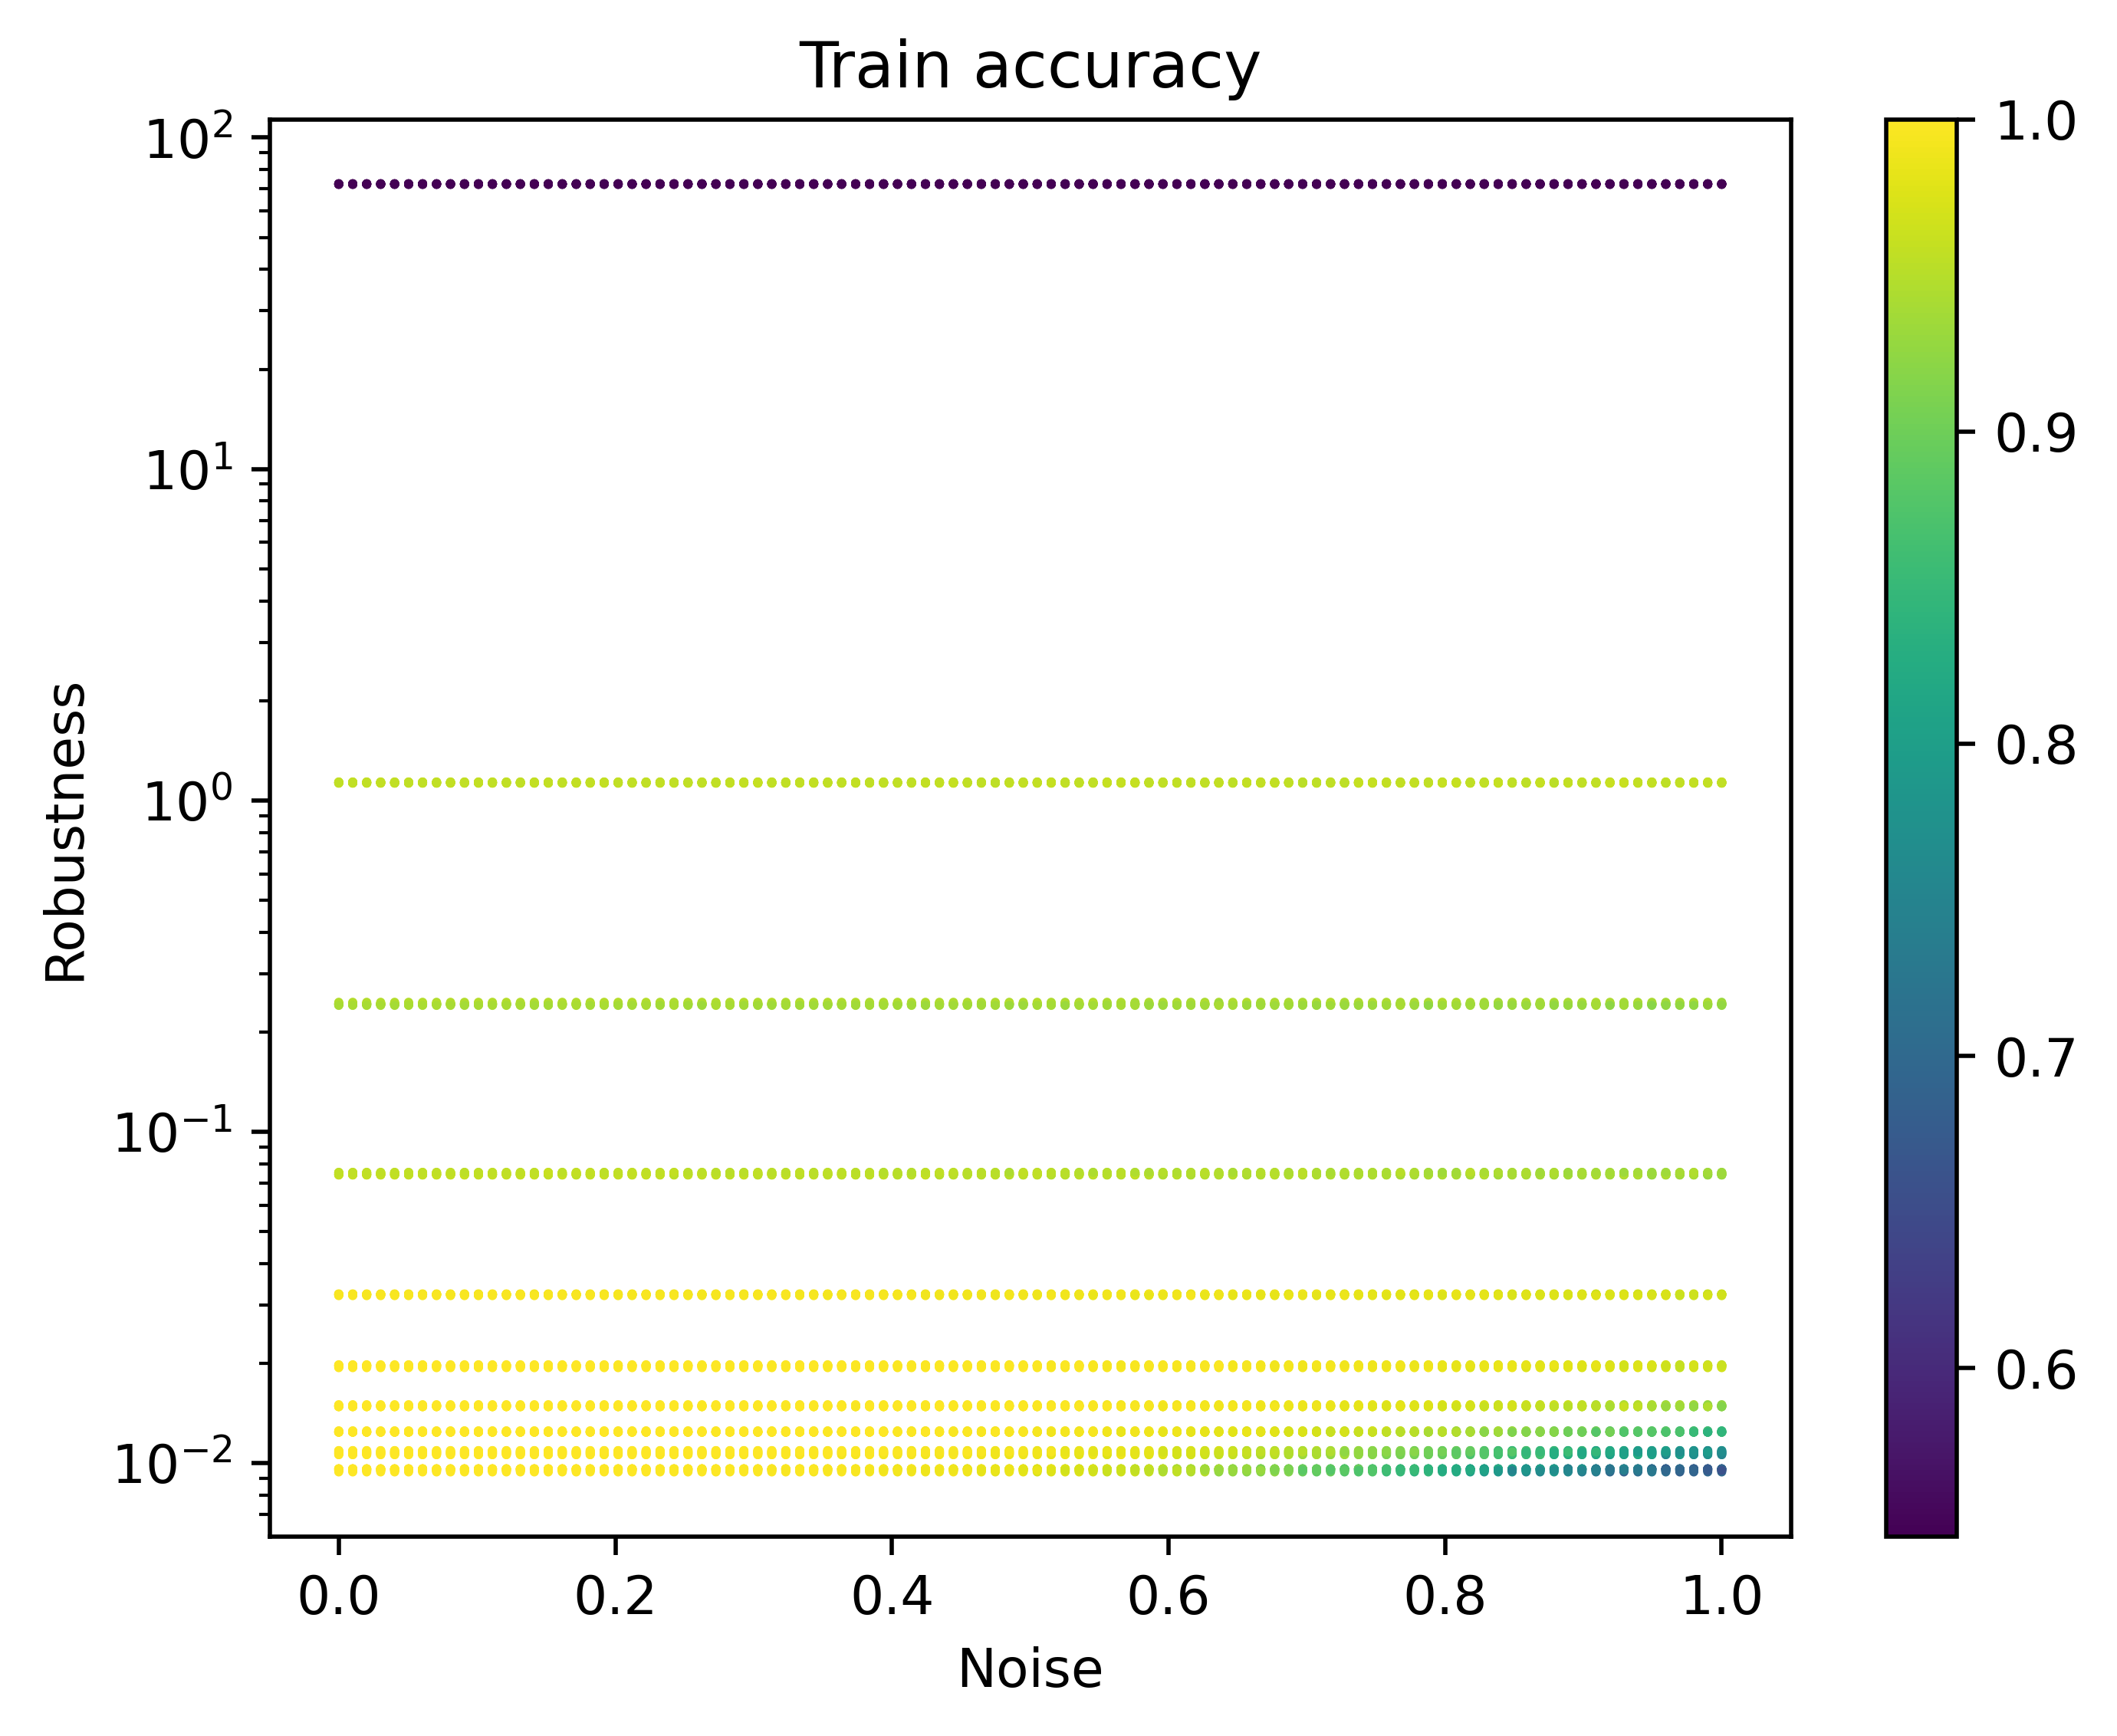

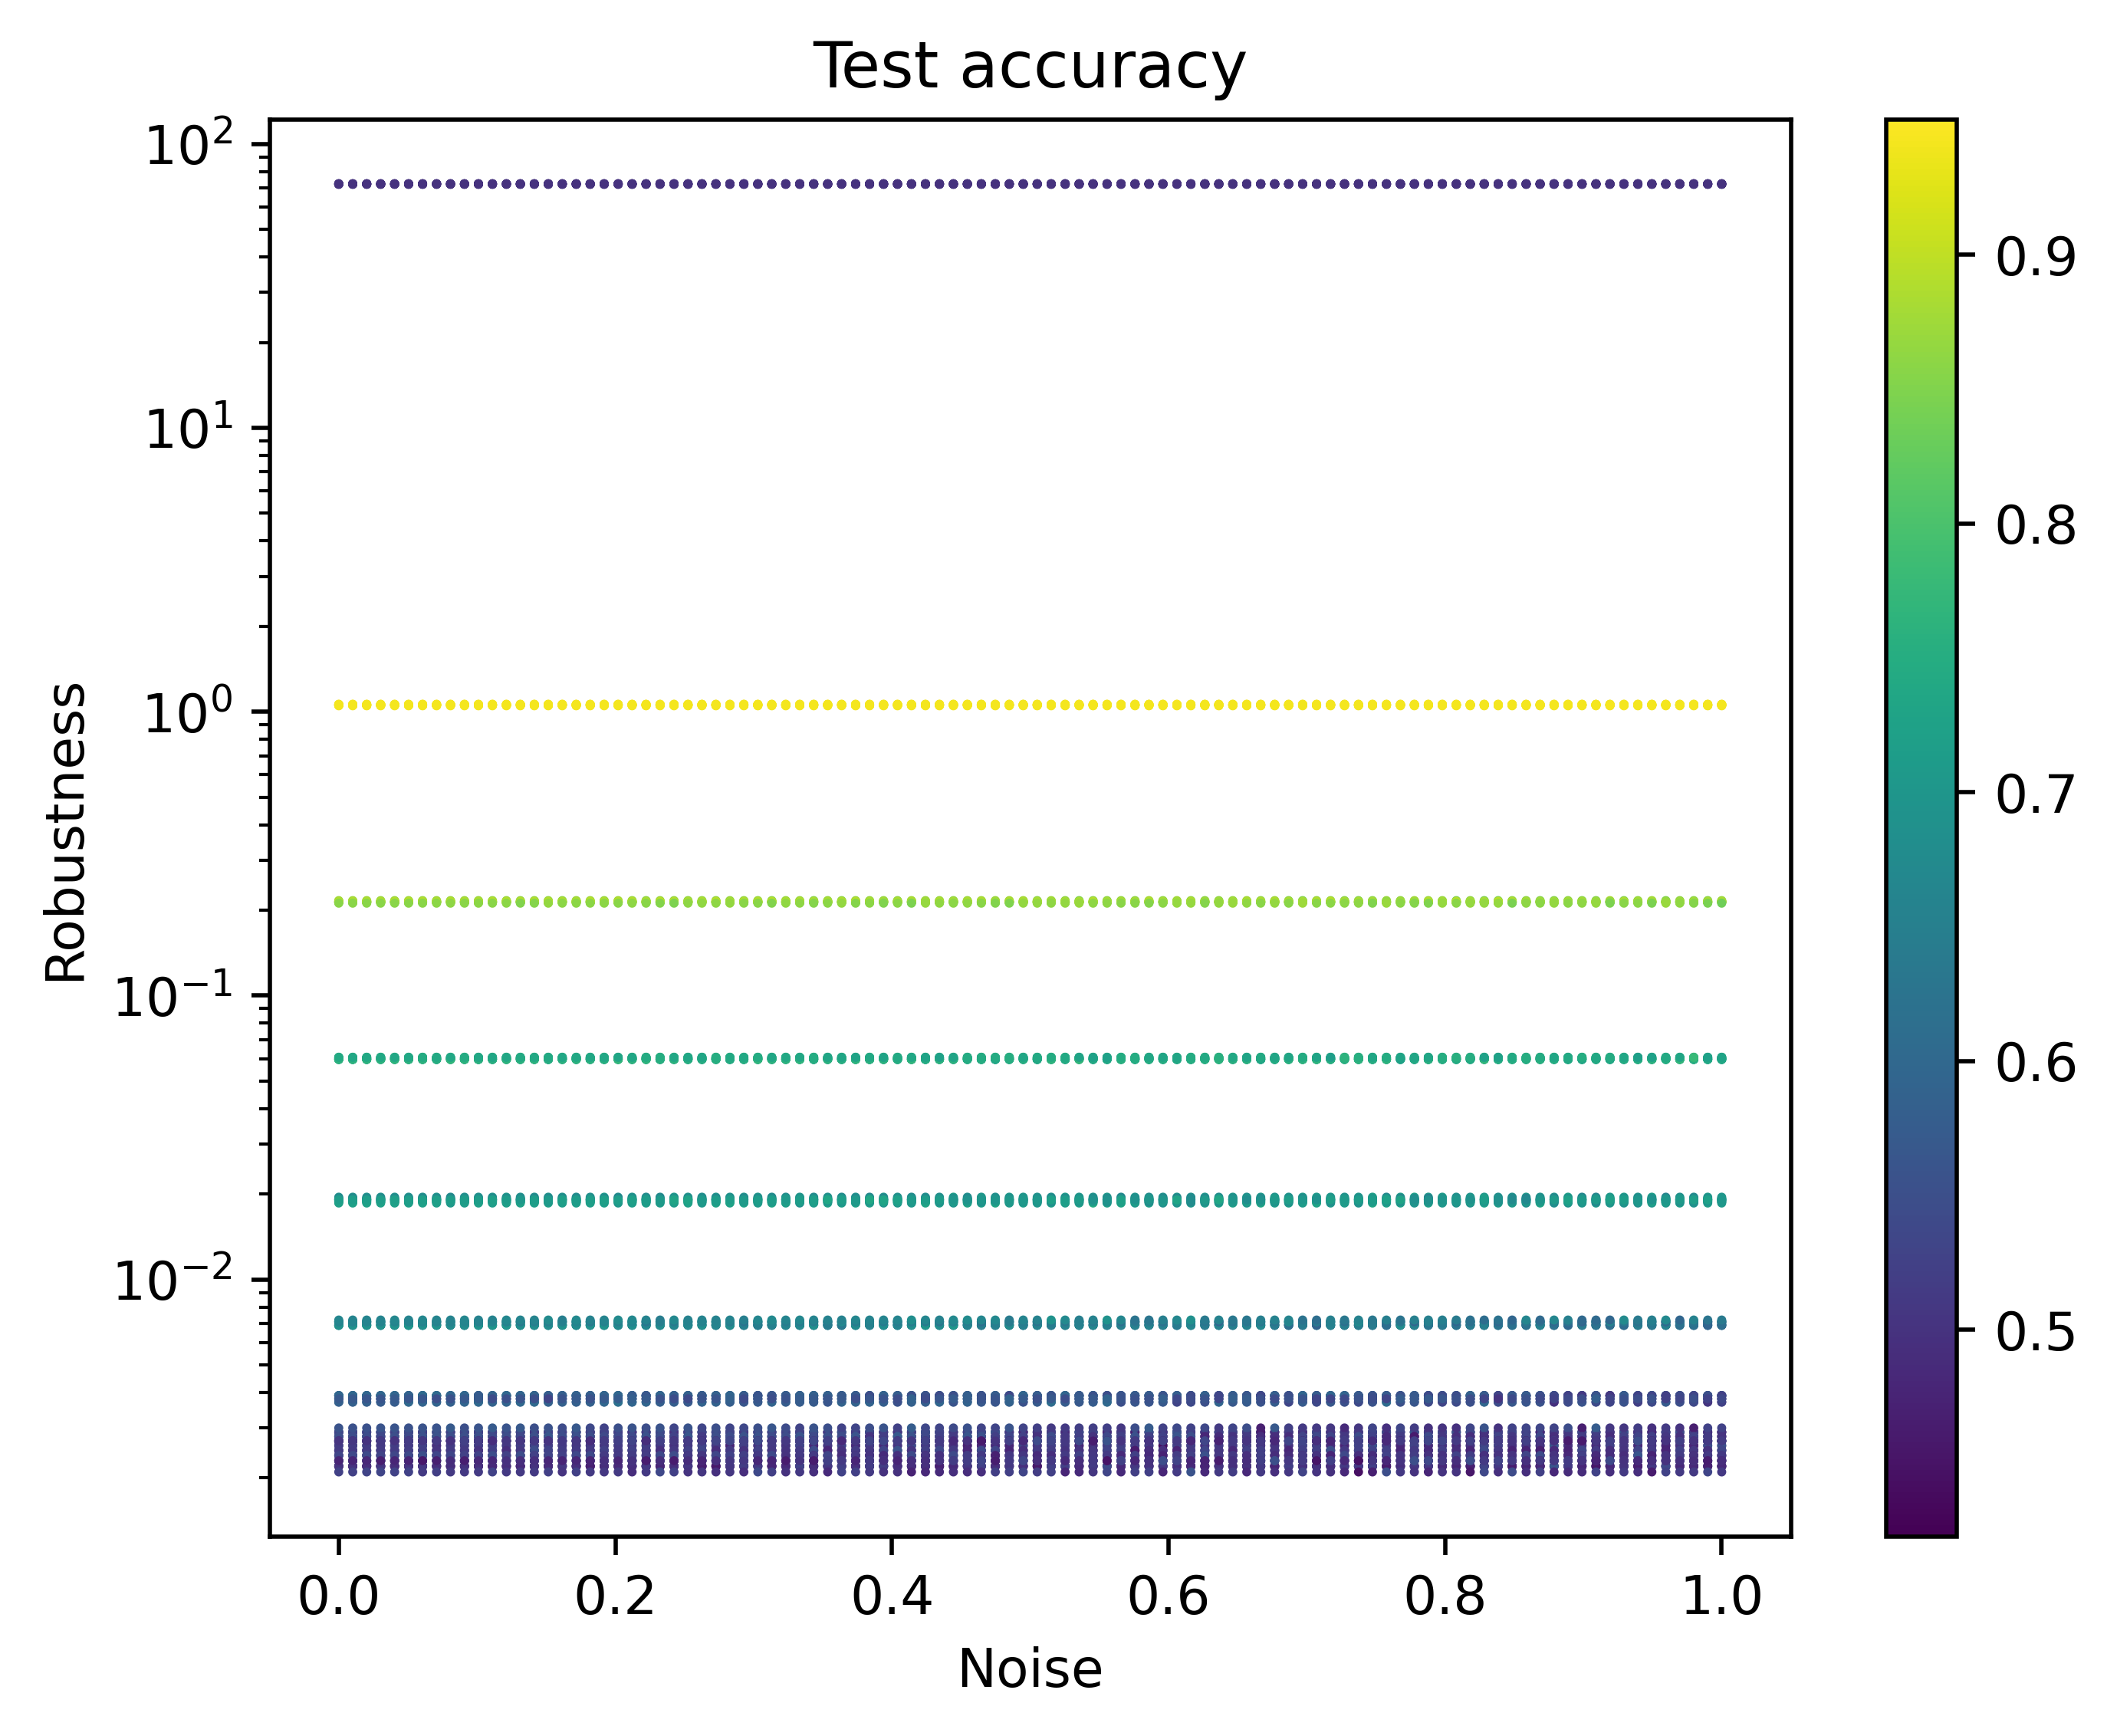

In [ ]:
|train_epsilons_, train_noise, train_acc = [], [], []
test_epsilons_, test_noise, test_acc = [], [], []
for train_epsilons, train_accuracies, test_epsilons, test_accuracies in results:
  for train_epsilon, train_accuracies_by_noise in zip(train_epsilons, train_accuracies):
    for noise, acc in zip(noises, train_accuracies_by_noise):
      train_epsilons_.append(train_epsilon.item())
      train_noise.append(noise.item())
      train_acc.append(acc.item())
  for test_epsilon, test_accuracies_by_noise in zip(test_epsilons, test_accuracies):
    for noise, acc in zip(noises, test_accuracies_by_noise):
      test_epsilons_.append(test_epsilon.item())
      test_noise.append(noise.item())
      test_acc.append(acc.item())
plt.figure(dpi=500)
sc = plt.scatter(train_noise, train_epsilons_, c=train_acc, s=0.5)
plt.colorbar(sc)
plt.yscale('log')
plt.xlabel('Noise')
plt.ylabel('Robustness')
plt.title('Train accuracy')
plt.show()
plt.figure(dpi=500)
sc = plt.scatter(test_noise, test_epsilons_, c=test_acc, s=0.5)
plt.colorbar(sc)
plt.yscale('log')
plt.xlabel('Noise')
plt.ylabel('Robustness')
plt.title('Test accuracy')
plt.show()